In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Importation de nos fichiers

df = pd.read_csv('data_clients.csv', sep=';')
rfm = pd.read_csv('rfm_clients.csv', sep=';')

# 1) Classifications RFM

## 1.1) K-Means

On effectue une standardisation des données afin de les mettre sur la même échelle. 

In [5]:
rfm = rfm.set_index('customer_unique_id')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

col = ['Récence', 'Fréquence', 'Montant']

scaled = rfm.copy()

scaler = StandardScaler()
scaled[col] = scaler.fit_transform(rfm[col])

On cherche à effectuer une segmentation des clients en groupes distincts. On va d'abord utiliser la méthode des K-Means. 

On va dans un premier temps utiliser 2 méthodes afin de déterminer le nombre de clusters : **méthode du coude** et **méthode de score silhouette**. 

### 1.1.1) Méthode du coude

On va utiliser **"KElbowVisualizer"** afin de sélectionner le nombre de clusters optimal pour la méthode du Kmeans. 

In [7]:
pip install yellowbrick

5: E999 SyntaxError: invalid syntax


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade yellowbrick

5: E999 SyntaxError: invalid syntax
1:14: E225 missing whitespace around operator


Note: you may need to restart the kernel to use updated packages.


In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [235]:
# On crée une fonction permettant de calculer le score
# d'inertie pour différents nombres de clusters
# et trançant la courbe du score d'inertie en fonction
# du nombre de clusters


def score_inertie(df):
    kmeans_model = KMeans(n_init=10)

    inertias = []
    for k in range(1, 11):
        kmeans_model.set_params(n_clusters=k)
        kmeans_model.fit(df)
        inertias.append(kmeans_model.inertia_)

    plt.plot(range(1, 11), inertias, marker='o')
    plt.title('Score d\'inertie en fonction du nombre'
              ' de clusters pour le Kmeans')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score d\'inertie')
    plt.show()

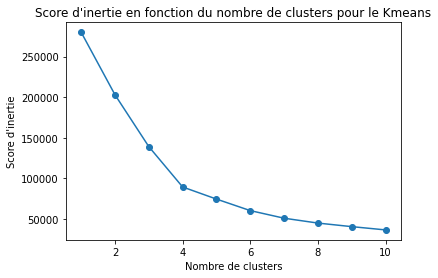

In [11]:
# On trace la courbe du score d'inertie en fonction
# du nombre de clusters
score_inertie(scaled)

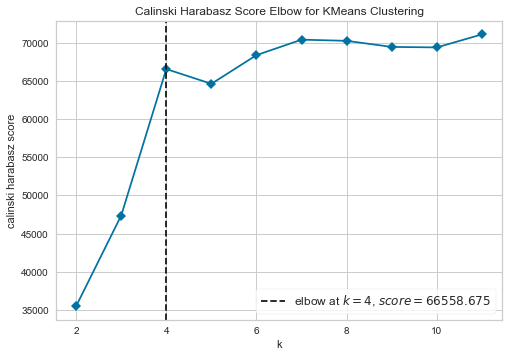

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [236]:
from yellowbrick.cluster import KElbowVisualizer
# Calcul du score de Calinski Harabasz selon le nombre de clusters
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 12), metric='calinski_harabasz', timings=False
)

visualizer.fit(scaled)
visualizer.show()

D'après les résultats pour la méthode du coude et le score de Calinski Harabasz tracé avec KElbowVisualizer, le nombre de clusters optimal serait de **4**. 

### 1.1.2) Méthode du score Silhouette

In [13]:
from sklearn.metrics import silhouette_score

# Liste des nombres de clusters à tester
k_values = range(2, 10)

# Calcul du score silhouette pour chaque nombre de clusters
for k in k_values:
    # Initialisation du modèle KMeans
    model = KMeans(n_clusters=k, n_init=10, random_state=0)

    # Entraînement du modèle sur les données
    model.fit(scaled)

    # Calcul du score silhouette pour le modèle entraîné
    silhouette = silhouette_score(scaled, model.labels_)

    print("Nombre de clusters : {}, Score silhouette : {}".format(
        k, silhouette))

Nombre de clusters : 2, Score silhouette : 0.7292254993612902
Nombre de clusters : 3, Score silhouette : 0.4508838434381841
Nombre de clusters : 4, Score silhouette : 0.4868556124460635
Nombre de clusters : 5, Score silhouette : 0.4975335998710711
Nombre de clusters : 6, Score silhouette : 0.43426720220586007
Nombre de clusters : 7, Score silhouette : 0.4366955242457208
Nombre de clusters : 8, Score silhouette : 0.4460239034258882
Nombre de clusters : 9, Score silhouette : 0.3946842344685291


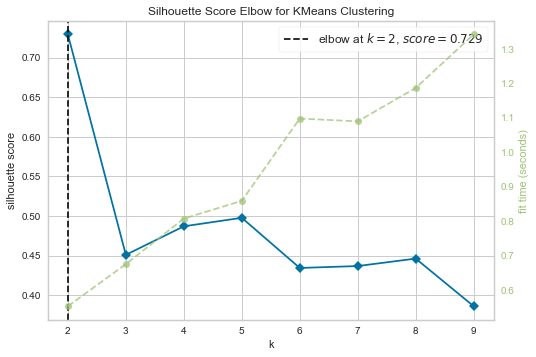

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [277]:
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# Génération de données aléatoires
X, y = make_blobs(n_samples=1000, centers=8, random_state=42)

# Initialisation du modèle KMeans
model = KMeans(n_init=10)

# Initialisation du visualiseur KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(2, 10),
                              metric='silhouette')

# Ajustement du visualiseur aux données
visualizer.fit(scaled)

# Affichage du graphique
visualizer.poof()

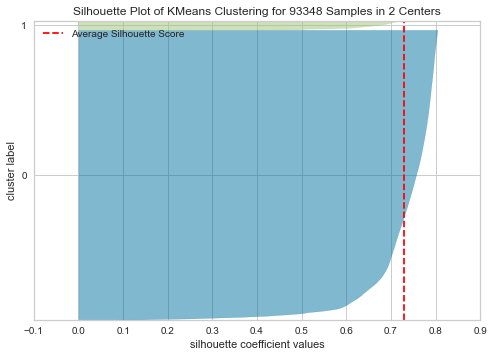

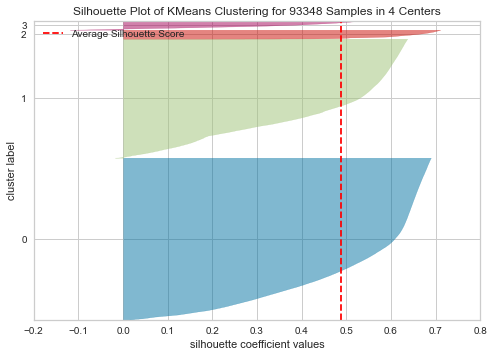

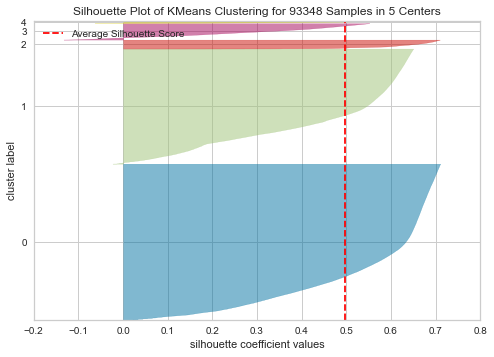

5:45: W291 trailing whitespace


In [15]:
from yellowbrick.cluster import SilhouetteVisualizer

K = [2, 4, 5]

# Initialisation de l'algorithme KMeans avec
# différents nombres de clusters
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans,
                                      colors='yellowbrick')
    visualizer.fit(scaled)
    visualizer.show()

Si on regarde de plus près avec **SilhouetteVisualizer**, on peut voir que pour k = 2, le groupe 0 est très large. Cela montre qu'il contient certainement des sous-groupes qu'on pourrait faire ressortir. 

Effectivement lorsque k = 4, on fait ressortir les sous-groupes et le groupe 0 et 2 semblent de même largeur. Néanmoins, le groupe 1 et 3 sont bien plus fins. 

Lorsque k = 5, peu de différences sont observées avec k = 4. Néanmoins, le dernier cluster n'est pas très visible. 

### 1.1.3) Pour k = 4

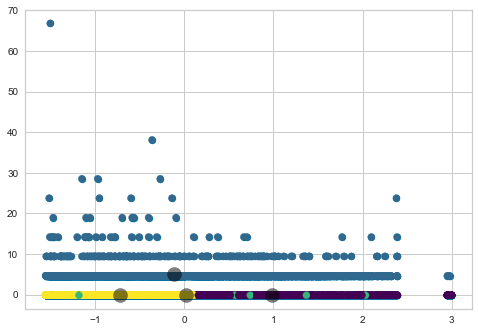

In [280]:
np.random.seed(42)

# Analyse de clustering Kmeans avec 4 clusters
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(scaled)

# Scatter plot des données en utilisant les deux features
plt.scatter(scaled['Récence'], scaled['Fréquence'], s=50)

# Colorisation de chaque point en fonction du cluster
# auquel il appartient
plt.scatter(scaled['Récence'], scaled['Fréquence'],
            c=kmeans.labels_, s=50, cmap='viridis')

# Etiquettes pour chaque cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            c='black', s=200, alpha=0.5)
plt.show()

In [281]:
from ipywidgets import interact, fixed


def plot_scatter_3d(elev, azim):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(scaled['Récence'],
               scaled['Fréquence'],
               scaled['Montant'], c=kmeans.labels_,
               s=35, edgecolor='k', cmap=plt.cm.Set1)
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Récence')
    ax.set_ylabel('Fréquence')
    ax.set_zlabel('Montant')
    ax.set_title('3D view of K-Means 4 clusters')
    ax.dist = 12

    ax.view_init(elev=elev, azim=azim)
    plt.show()

# Utiliser la fonction interact pour créer
# l'interface utilisateur


interact(plot_scatter_3d, elev=(-90, 90, 5),
         azim=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90, step=5), IntSlider(value=0, desc…

<function __main__.plot_scatter_3d(elev, azim)>

In [282]:
# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=4)
kmeans.fit(scaled)
rfm['Clusters'] = (kmeans.labels_ + 1)

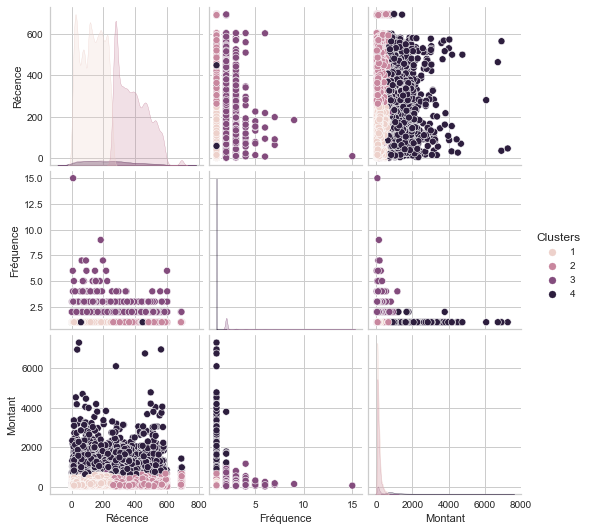

In [283]:
# Visualisation graphique de nos clusters
sns.pairplot(rfm, hue="Clusters")

In [284]:
# On standardise nos données
from sklearn.preprocessing import StandardScaler
var = ['Récence', 'Fréquence', 'Montant']

scaler = StandardScaler()
rfm[['Récence_stand', 'Fréquence_stand',
     'Montant_stand']] = scaler.fit_transform(rfm[var])

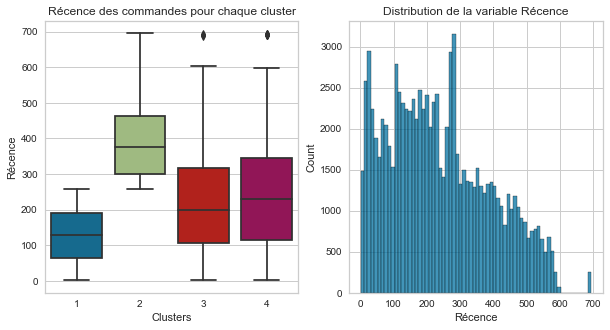

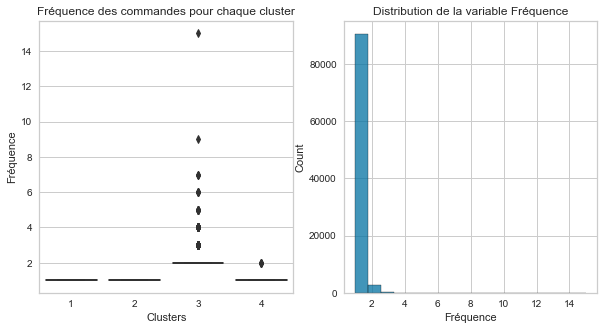

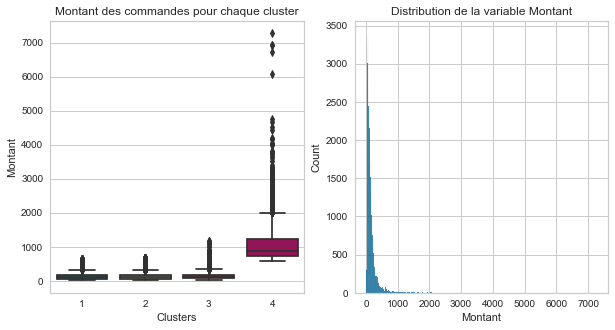

In [285]:
# On effectue les boxplots des clusters pour chaque variable
var_stand = ['Récence', 'Fréquence', 'Montant']

for i in var_stand:
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    sns.boxplot(x=rfm['Clusters'], y=rfm[i], ax=ax[0])
    ax[0].set_title(i+' des commandes pour chaque cluster')
    sns.histplot(rfm[i], ax=ax[1])
    ax[1].set_title('Distribution de la variable ' + i)
    plt.show()

Après avoir effectué les boxplots et histogrammes pour chaque variable, nous observons (surtout pour la fréquence et le montant), des valeurs aberrantes. De plus, les histogrammes montrent que les données sont asymétriques. La moyenne étant sensible aux valeurs extrêmes, la **médiane** peut être préférée pour **regrouper les clusters**. 

In [286]:
# On regroupe nos clusters en calculant leur
# médiane pour chaque variable
group_mediane = rfm.groupby(['Clusters'])[[
    'Récence', 'Fréquence', 'Montant']].median()
group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant
Clusters,,,
1,130.000000,1.000000,103.260000
2,376.000000,1.000000,101.035000
3,199.000000,2.000000,111.108333
4,228.500000,1.000000,874.785000


D'après la moyenne obtenue pour chaque cluster, nous pouvons en déduire les observations suivantes : 
- **Cluster 1** : clients achetant à des montants faibles et ayant effectué uniquement 1 seul achat, mais dont les achats sont les plus récents (130 jours = environ 4 mois). 
- **Cluster 2** : clients achetant à des montants faibles et ayant effectué uniquement 1 seul achat et dont les achats sont les moins récents (> 1 an). 
- **Cluster 3** : clients achetant à des montant ni trop faibles, ni trop élevés, ayant effectué plusieurs achats (> 2) et dont les achats restent récents (< 1 an). 
- **Cluster 4** : clients achetant à des montants très élevés et ayant effectué 1 achat et dont les achats sont moins récents (< 1an). 

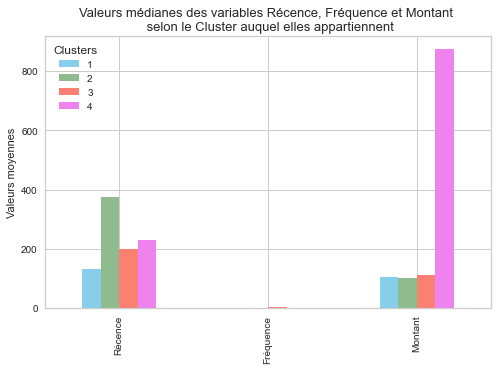

In [287]:
# Représentations graphiques des différents clusters

# Barplot
group_mediane.transpose().plot(kind='bar', figsize=(8, 5),
                               color=['skyblue', 'darkseagreen',
                                      'salmon', 'violet'])
plt.ylabel('Valeurs moyennes')
plt.title('Valeurs médianes des variables Récence, Fréquence'
          ' et Montant \n selon le Cluster auquel elles appartiennent',
          size=13)
plt.show()

In [288]:
rfm['Clusters'].value_counts()

1    50628
2    37168
3     2796
4     2756
Name: Clusters, dtype: int64

In [289]:
def func(row):
    if row['Clusters'] == 1:
        return 'Clients peu dépensiers mais récents'
    elif row['Clusters'] == 4:
        return 'Clients très dépensiers'
    elif row['Clusters'] == 3:
        return 'Clients avec de bonnes dépenses et fréquents'
    else:
        return 'Clients anciens, peu fréquents, faibles dépenses'

In [290]:
rfm['Clients'] = rfm.apply(func, axis=1)

In [291]:
rfm.Clients.value_counts()

Clients peu dépensiers mais récents                 50628
Clients anciens, peu fréquents, faibles dépenses    37168
Clients avec de bonnes dépenses et fréquents         2796
Clients très dépensiers                              2756
Name: Clients, dtype: int64

In [292]:
# On crée une fonction permettant de tracer
# un camembert avec une légende


def pie(df, col, titre):

    fig1, ax1 = plt.subplots(figsize=(8, 5))
    fig1.subplots_adjust(0.3, 0, 1, 1)

    plt.title(titre, size=15)
    theme = plt.get_cmap('jet')
    ax1.set_prop_cycle("color",
                       [theme(1. * i / len(
                           df[col].value_counts()))
                        for i in range(len(df[col].value_counts()))])

    wedges, _ = ax1.pie(df[col].value_counts(), startangle=90, radius=1800)

    ax1.axis('equal')

    total = sum(df[col].value_counts())
    plt.legend(
        loc='upper right',
        labels=['%s, %1.1f%%' % (
            category_name, (float(s) / total) * 100)
                for category_name, s in zip(
                    df[col].value_counts().index, df[col].value_counts())],
        prop={'size': 11},
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure
    )

    plt.show()

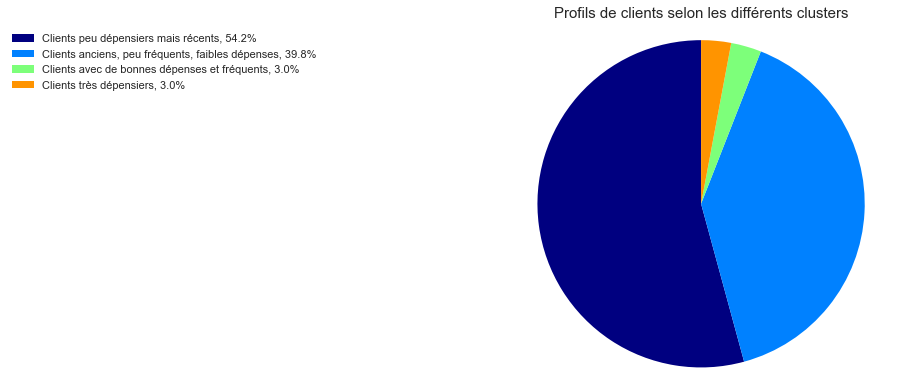

In [293]:
# On trace notre diagramme en camembert selon les différents clusters
pie(rfm, 'Clients', 'Profils de clients selon les différents clusters')

In [294]:
import plotly.graph_objects as go

On va créer une fonction transformant les valeurs des variables qui nous intéressent en les mettant à l'échelle entre 0 et 100. 

In [295]:
# Création de notre fonction


def trans_var_3(var1, var2, var3, df):
    # On sélectionne les variables à utiliser
    var = [var1, var2, var3]

    # On met à l'échelle de 0 à 100
    new_max = 100
    new_min = 0
    new_range = new_max - new_min

    # Transformation linéaire pour chaque variable
    for factor in var:
        max_val = group_mediane[factor].max()
        min_val = group_mediane[factor].min()
        val_range = max_val - min_val
        df[factor+'_Adj'] = df[factor].apply(
          lambda x: (((x - min_val)*new_range)/val_range)+new_min)
    return df

In [296]:
# Création de nos nouvelles variables
radar_4 = trans_var_3('Récence', 'Fréquence', 'Montant', group_mediane)

In [297]:
# On renomme nos nouvelles colonnes
radar_4 = radar_4.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes'})

In [298]:
radar_4

,Récence,Fréquence,Montant,Commandes_récentes,Nombre_commandes,Dépenses_commandes
Clusters,,,,,,
1,130.0,1.0,103.260000,0.00000,0.0,0.287561
2,376.0,1.0,101.035000,100.00000,0.0,0.000000
3,199.0,2.0,111.108333,28.04878,100.0,1.301885
4,228.5,1.0,874.785000,40.04065,0.0,100.000000


In [299]:
# On crée une fonction affichant la carte radar multiple


def radar_chart_3(new_var1, new_var2, new_var3, new_df):
    var = [new_var1, new_var2, new_var3]

    fig = go.Figure()

    for i in range(1, new_df.shape[0]+1):
        fig.add_trace(go.Scatterpolar(
          r=new_df.loc[i, var].tolist(),
          theta=var,
          fill='toself',
          name=i
        ))
    fig.show()

In [300]:
# On affiche notre carte radar
radar_chart_3('Commandes_récentes', 'Nombre_commandes',
              'Dépenses_commandes', radar_4)

Regardons le profil des clients. 

In [301]:
rfm_copy = rfm[['Récence', 'Fréquence', 'Montant',
                'Clusters']].reset_index()
merge = pd.merge(df[['categorie_commune', 'Mode_paiement_récurrent',
                     'customer_unique_id']], rfm_copy,
                 on='customer_unique_id', how='right')

In [302]:
# On supprime les doublons
merge = merge.drop_duplicates(keep='first')

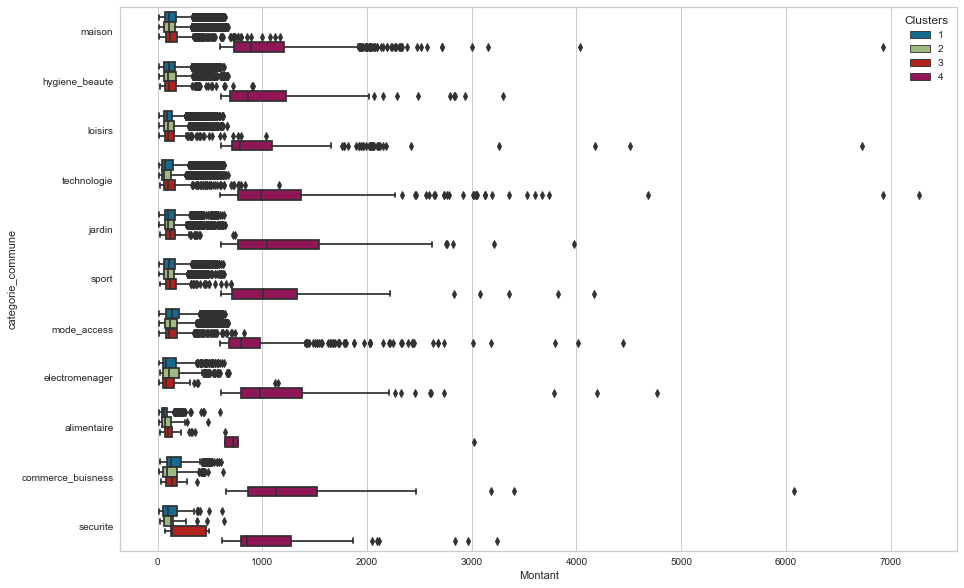

In [303]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Montant", y="categorie_commune", hue="Clusters", data=merge)
plt.show()

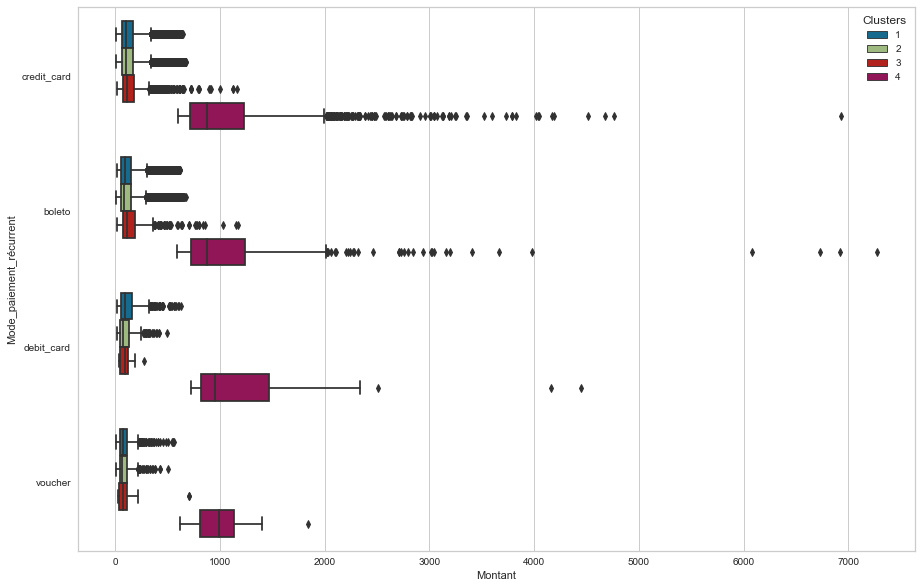

In [304]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Montant", y="Mode_paiement_récurrent", hue="Clusters",
            data=merge)
plt.show()

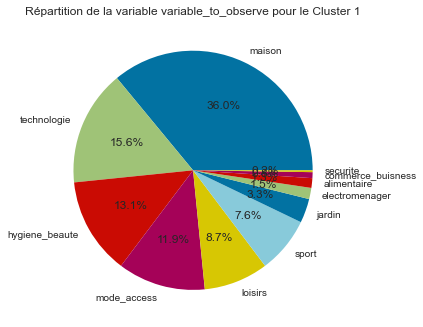

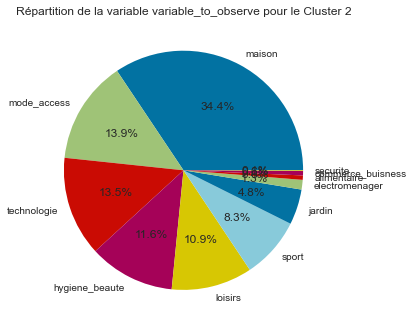

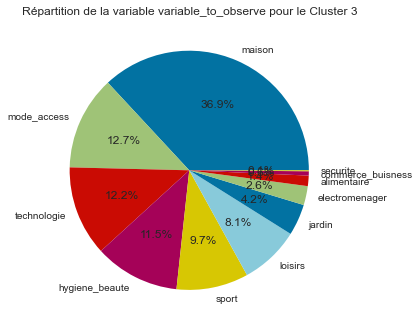

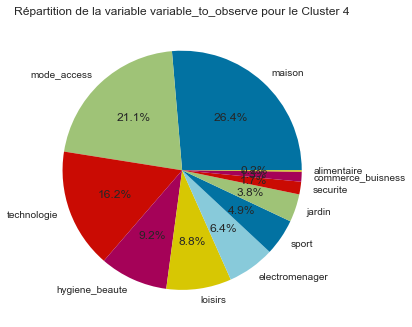

In [305]:
# Regardons les catégories pour chaque cluster
grouped = merge.groupby('Clusters')

for group_name, group_data in grouped:
    value_counts = group_data["categorie_commune"].value_counts()
    plt.figure()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title("Répartition de la variable {} pour le Cluster {}".format(
        "variable_to_observe", group_name))
    plt.show()

### 1.1.4) Pour k = 3

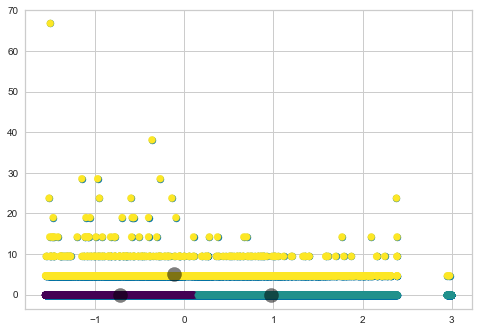

In [42]:
np.random.seed(42)

# Analyse de clustering Kmeans avec 4 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(scaled)

# Scatter plot des données en utilisant les deux features
plt.scatter(scaled['Récence'], scaled['Fréquence'], s=50)

# Colorisation de chaque point en fonction du cluster auquel il appartient
plt.scatter(scaled['Récence'], scaled['Fréquence'], c=kmeans.labels_,
            s=50, cmap='viridis')

# Etiquettes pour chaque cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [43]:
# Utiliser la fonction interact pour créer l'interface utilisateur
interact(plot_scatter_3d, elev=(-90, 90, 5), azim=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90, step=5), IntSlider(value=0, desc…

<function __main__.plot_scatter_3d(elev, azim)>

In [44]:
# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=3)
kmeans.fit(scaled)
rfm['Clusters'] = (kmeans.labels_ + 1)

In [45]:
# On standardise nos données
from sklearn.preprocessing import StandardScaler
var = ['Récence', 'Fréquence', 'Montant']

scaler = StandardScaler()
rfm[['Récence_stand', 'Fréquence_stand',
     'Montant_stand']] = scaler.fit_transform(rfm[var])

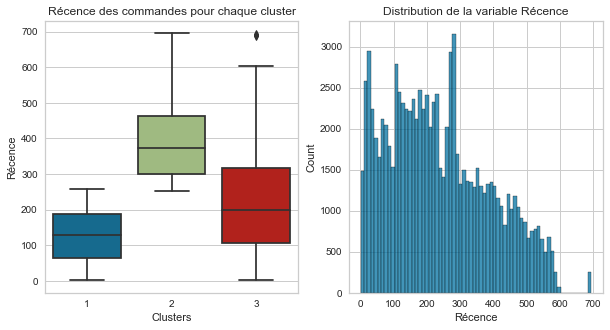

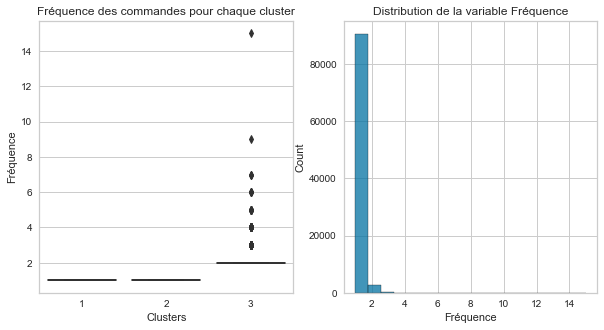

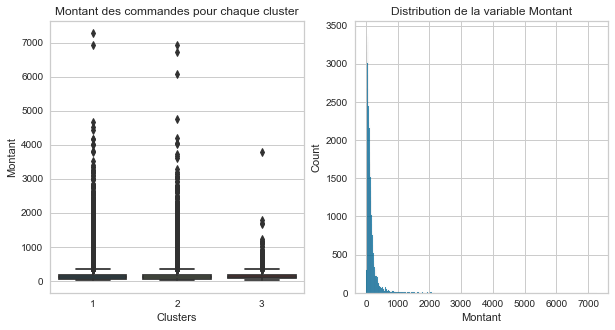

In [46]:
# On effectue les boxplots des clusters pour chaque variable
var_stand = ['Récence', 'Fréquence', 'Montant']

for i in var_stand:
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    sns.boxplot(x=rfm['Clusters'], y=rfm[i], ax=ax[0])
    ax[0].set_title(i + ' des commandes pour chaque cluster')
    sns.histplot(rfm[i], ax=ax[1])
    ax[1].set_title('Distribution de la variable ' + i)
    plt.show()

In [47]:
# On regroupe nos clusters en calculant
# leur médiane pour chaque variable
group_mediane = rfm.groupby(['Clusters'])[['Récence',
                                           'Fréquence', 'Montant']].median()

group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant
Clusters,,,
1,129.000000,1.000000,106.730000
2,374.000000,1.000000,104.370000
3,199.000000,2.000000,111.150000


A partir des valeurs médianes, on en déduit les observations suivantes : 
- **Cluster 1** : clients ayant commandé très récemment, mais à une fréquence de 1 commande par personne et avec de faibles montants. 
- **Cluster 2** : clients dont les commandes sont les moins récentes (> 1 an), ayant effectué seulement 1 commande et dont le montant est le plus faible. 
- **Cluster 3** : clients dont les commandes restent assez récentes, mais ayant effectué plusieurs commandes et dont le montant est le plus élevé. 

In [48]:
rfm['Clusters'].value_counts()

1    51938
2    38609
3     2801
Name: Clusters, dtype: int64

In [49]:
# On crée une fonction attribuant un critère aux différents clusters
def func(row):
    if row['Clusters'] == 1:
        return 'Derniers clients en date, peu dépensiers'
    elif row['Clusters'] == 2:
        return 'Clients rares et peu dépensiers'
    else:
        return 'Clients dépensiers et fréquents '

In [50]:
rfm['Clients'] = rfm.apply(func, axis=1)

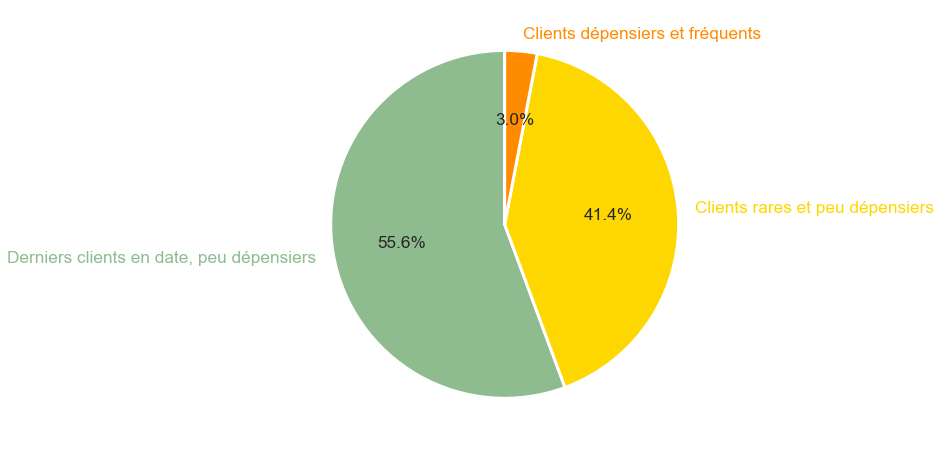

In [51]:
# Graphique en camembert
colors = ['darkseagreen', 'gold', 'darkorange', 'red']
fig, ax = plt.subplots(figsize=(8, 8))
patches, texts, pcts = ax.pie(
    x=rfm.Clients.value_counts(),
    labels=rfm.Clients.value_counts().index, autopct='%1.1f%%', colors=colors,
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90,
    labeldistance=1.1)

for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())

plt.show()

In [52]:
# Création de nos nouvelles variables mises à l'échelle
radar_3 = trans_var_3('Récence', 'Fréquence',
                      'Montant', group_mediane)

In [53]:
# On renomme nos nouvelles colonnes
radar_3 = radar_3.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes'})

In [54]:
# On affiche notre carte radar
radar_chart_3('Commandes_récentes', 'Nombre_commandes',
              'Dépenses_commandes', radar_3)

En partant sur 3 clusters, il semble manquer des catégories intéressantes de clients dont les sommes dépensées sont très élevées par exemple. 

### 1.1.5) Pour k = 5

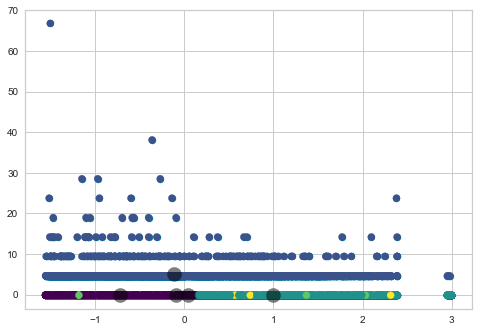

In [55]:
np.random.seed(42)

# Analyse de clustering Kmeans avec 5 clusters
kmeans = KMeans(n_clusters=5, n_init=10,
                random_state=0).fit(scaled)

# Scatter plot des données en utilisant les deux features
plt.scatter(scaled['Récence'], scaled['Fréquence'], s=50)

# Colorisation de chaque point en fonction du cluster
# auquel il appartient
plt.scatter(scaled['Récence'], scaled['Fréquence'],
            c=kmeans.labels_, s=50, cmap='viridis')

# Etiquettes pour chaque cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            c='black', s=200, alpha=0.5)
plt.show()

In [56]:
# Utiliser la fonction interact pour créer l'interface utilisateur
interact(plot_scatter_3d, elev=(-90, 90, 5), azim=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90, step=5), IntSlider(value=0, desc…

<function __main__.plot_scatter_3d(elev, azim)>

In [57]:
# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=5)
kmeans.fit(scaled)
rfm['Clusters'] = (kmeans.labels_ + 1)

In [58]:
# On standardise nos données
from sklearn.preprocessing import StandardScaler
var = ['Récence', 'Fréquence', 'Montant']

scaler = StandardScaler()
rfm[['Récence_stand', 'Fréquence_stand',
     'Montant_stand']] = scaler.fit_transform(rfm[var])

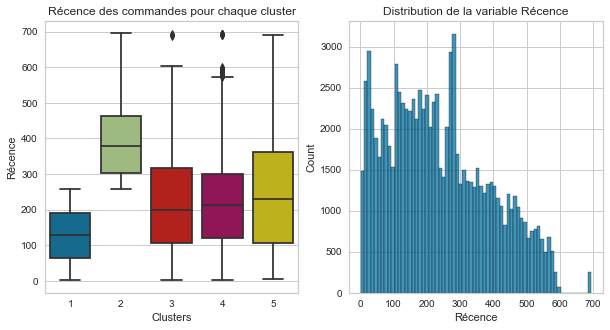

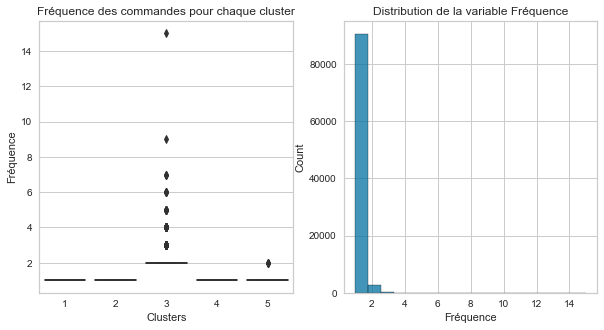

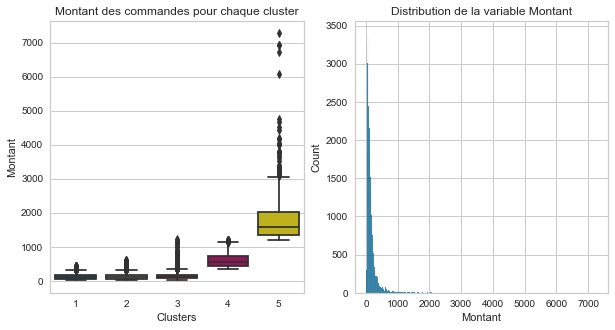

In [59]:
# On effectue les boxplots des clusters pour chaque variable
var_stand = ['Récence', 'Fréquence', 'Montant']

for i in var_stand:
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    sns.boxplot(x=rfm['Clusters'], y=rfm[i], ax=ax[0])
    ax[0].set_title(i + ' des commandes pour chaque cluster')
    sns.histplot(rfm[i], ax=ax[1])
    ax[1].set_title('Distribution de la variable ' + i)
    plt.show()

In [60]:
# On regroupe nos clusters en calculant leur médiane pour chaque variable
group_mediane = rfm.groupby(['Clusters'])[
    ['Récence', 'Fréquence', 'Montant']].median()
group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant
Clusters,,,
1,129.000000,1.000000,99.430000
2,378.000000,1.000000,97.870000
3,199.000000,2.000000,111.116667
4,212.000000,1.000000,556.750000
5,230.000000,1.000000,1584.960000


In [61]:
rfm['Clusters'].value_counts()

1    48766
2    35947
4     5103
3     2797
5      735
Name: Clusters, dtype: int64

In [62]:
# On crée une fonction attribuant un critère aux différents clusters


def func(row):
    if row['Clusters'] == 1:
        return 'Derniers clients en date, peu dépensiers'
    elif row['Clusters'] == 4:
        return 'Clients avec de bonnes dépenses'
    elif row['Clusters'] == 2:
        return 'Clients rares'
    elif row['Clusters'] == 3:
        return 'Clients assez dépensiers, récents et plus fréquents'
    else:
        return 'Clients très dépensiers'

In [63]:
rfm['Clients'] = rfm.apply(func, axis=1)

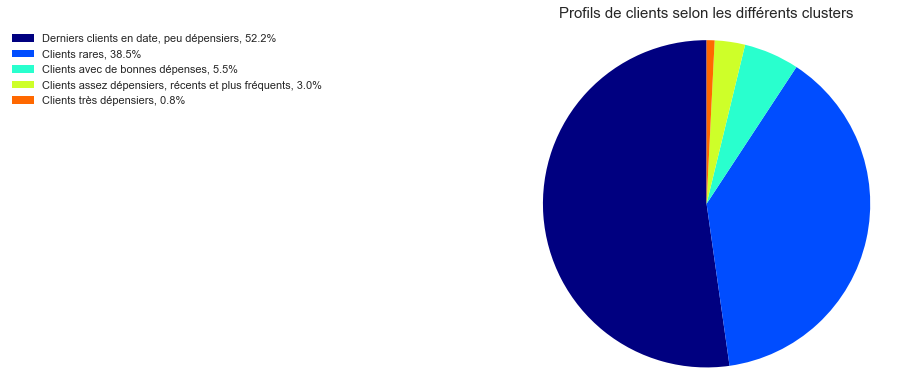

In [64]:
# On trace notre diagramme en camembert selon les différents clusters
pie(rfm, 'Clients', 'Profils de clients selon les différents clusters')

In [65]:
# Création de nos nouvelles variables mises à l'échelle
radar_5 = trans_var_3('Récence', 'Fréquence',
                      'Montant', group_mediane)

In [66]:
# On renomme nos nouvelles colonnes
radar_5 = radar_5.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes'})

In [67]:
# On affiche notre carte radar
radar_chart_3('Commandes_récentes', 'Nombre_commandes',
              'Dépenses_commandes', radar_5)

Le fait de prendre k = 5 clusters, permet d'avoir des groupes plus spécifiques. 

### 1.1.5) Pour k = 6

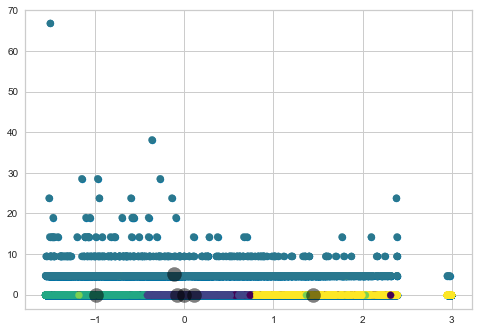

In [68]:
np.random.seed(42)

# Analyse de clustering Kmeans avec 6 clusters
kmeans = KMeans(n_clusters=6, n_init=10,
                random_state=0).fit(scaled)

# Scatter plot des données en utilisant les deux features
plt.scatter(scaled['Récence'], scaled['Fréquence'], s=50)

# Colorisation de chaque point en fonction du cluster
# auquel il appartient
plt.scatter(scaled['Récence'], scaled['Fréquence'],
            c=kmeans.labels_, s=50, cmap='viridis')

# Etiquettes pour chaque cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black',
            s=200, alpha=0.5)
plt.show()

In [69]:
# Utiliser la fonction interact pour créer l'interface utilisateur
interact(plot_scatter_3d, elev=(-90, 90, 5), azim=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90, step=5), IntSlider(value=0, desc…

<function __main__.plot_scatter_3d(elev, azim)>

In [70]:
# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=6)
kmeans.fit(scaled)
rfm['Clusters'] = (kmeans.labels_ + 1)

In [71]:
# On standardise nos données
from sklearn.preprocessing import StandardScaler
var = ['Récence', 'Fréquence', 'Montant']

scaler = StandardScaler()
rfm[['Récence_stand', 'Fréquence_stand',
     'Montant_stand']] = scaler.fit_transform(rfm[var])

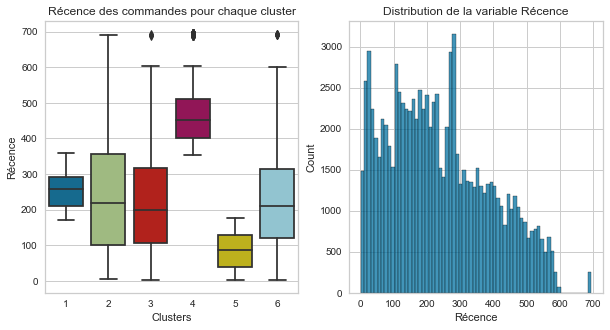

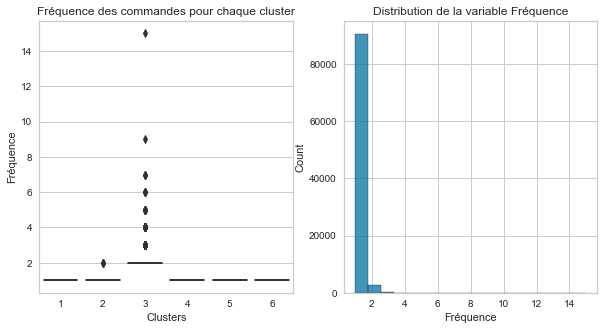

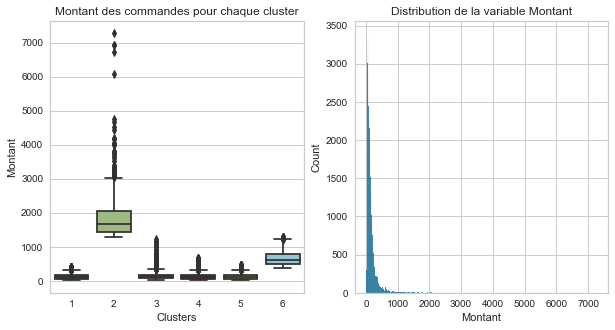

In [72]:
# On effectue les boxplots des clusters pour chaque variable
var_stand = ['Récence', 'Fréquence', 'Montant']

for i in var_stand:
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    sns.boxplot(x=rfm['Clusters'], y=rfm[i], ax=ax[0])
    ax[0].set_title(i + ' des commandes pour chaque cluster')
    sns.histplot(rfm[i], ax=ax[1])
    ax[1].set_title('Distribution de la variable ' + i)
    plt.show()

In [73]:
# On regroupe nos clusters en calculant leur médiane
# pour chaque variable
group_mediane = rfm.groupby(['Clusters'])[['Récence',
                                           'Fréquence', 'Montant']].median()
group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant
Clusters,,,
1,258.000000,1.000000,97.710000
2,218.000000,1.000000,1674.190000
3,199.000000,2.000000,111.116667
4,452.000000,1.000000,98.790000
5,87.000000,1.000000,102.270000
6,211.000000,1.000000,611.395000


D'après nos observations : 
- **Cluster 1** : clients dont les commandes sont les plus récentes (< 3 mois). 
- **Cluster 2** : clients dont les dépenses sont les plus faibles (96 R$ par commande)
- **Cluster 3** : clients dont la fréquence d'achat est la plus élevée (> 1 commande) et restent récentes (< 7 mois)
- **Cluster 4** : clients dont les dépenses sont assez élevées (609 R par commande) et restent également récentes (< 7 mois)
- **Cluster 5** : clients dont les dépenses sont les plus élevées (1660 par commande)
- **Cluster 6** : clients dont les dépenses restent faibles (99 R par commande) et dont les dernières commandes datent d'il y plus d'un an (15 mois environ) et dont la fréquence d'achat est faible. 

In [74]:
rfm['Clusters'].value_counts()

5    32896
1    32251
4    20370
6     4408
3     2797
2      626
Name: Clusters, dtype: int64

In [75]:
# On crée une fonction attribuant un critère aux différents clusters


def func(row):
    if row['Clusters'] == 5:
        return 'Récents'
    elif row['Clusters'] == 1:
        return 'Dépenses faibles'
    elif row['Clusters'] == 3:
        return 'Récents et achats plus fréquents'
    elif row['Clusters'] == 6:
        return 'Dépenses élevées et encore récentes'
    elif row['Clusters'] == 2:
        return 'Dépenses très élevées'
    else:
        return 'Dépenses faibles et anciens'

In [76]:
rfm['Clients'] = rfm.apply(func, axis=1)

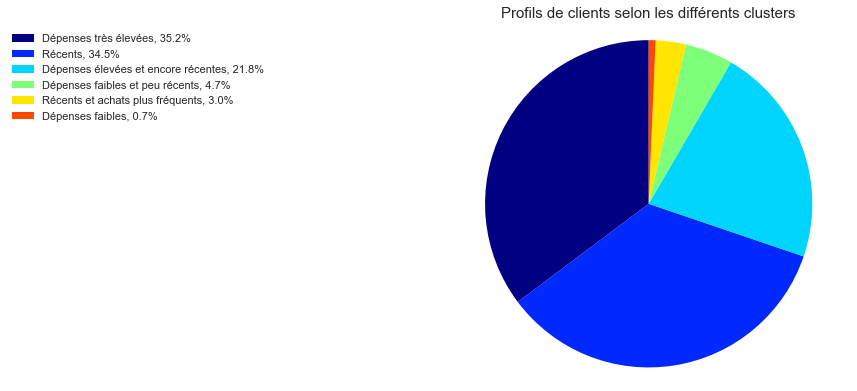

In [77]:
# On trace notre diagramme en camembert selon les différents clusters
pie(rfm, 'Clients', 'Profils de clients selon les différents clusters')

In [78]:
# Création de nos nouvelles variables mises à l'échelle
radar_6 = trans_var_3('Récence', 'Fréquence', 'Montant',
                      group_mediane)

In [79]:
# On renomme nos nouvelles colonnes
radar_6 = radar_6.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes'})

In [80]:
# On affiche notre carte radar
radar_chart_3('Commandes_récentes', 'Nombre_commandes',
              'Dépenses_commandes', radar_6)

On décide de garder un nombre de clusters **k = 4** en suivant le résultat de la **méthode du coude**. On va calculer des métriques communes aux différentes méthodes permettant d'évaluer leur qualité de clustering.

In [81]:
import time

start_time = time.time()

# On applique le KMeans sur nos données standardisées
kmeans = KMeans(n_init=10, n_clusters=4)
kmeans.fit(scaled)
# On prédit les clusters pour chaque observation,
# puis on les stocke dans la variable "labels"
labels_kmeans = kmeans.predict(scaled)

In [82]:
# On calcule le score silhouette
silhouette_kmeans = silhouette_score(scaled, labels_kmeans)

In [83]:
from sklearn.metrics import davies_bouldin_score

# On calcule l'indice de Davies-Bouldin
db_kmeans = davies_bouldin_score(scaled, labels_kmeans)

In [84]:
from sklearn.metrics import calinski_harabasz_score

# On calcule l'indice de Calinski-Harabasz
ch_kmeans = calinski_harabasz_score(scaled, labels_kmeans)

end_time = time.time()
kmeans_time = end_time - start_time

In [85]:
resultat_kmeans = pd.DataFrame(
    {'Silhouette_score': silhouette_kmeans,
     'Davies_bouldin_score': db_kmeans,
     'Calinski_harabasz_score': ch_kmeans,
     'Time': kmeans_time}, index=['Kmeans'])

resultat_kmeans

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.486856,0.669867,66558.674708,99.187338


## 1.2) DBSCAN

In [86]:
from sklearn.cluster import DBSCAN

Dans un premier temps, on va chercher les meilleurs paramètres de DBSCAN (eps). 

In [87]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(scaled)
distances, indices = nbrs.kneighbors(scaled)

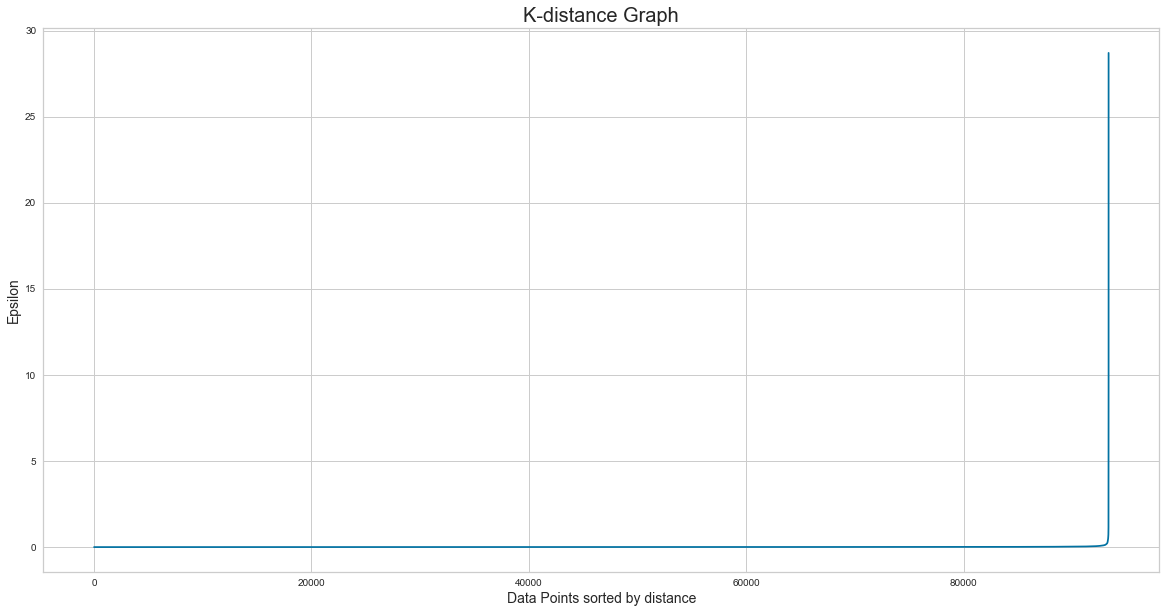

In [88]:
# Graphique K-distance
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(20, 10))
plt.plot(distances)
plt.title('K-distance Graph', fontsize=20)
plt.xlabel('Data Points sorted by distance', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:30<00:00, 10.08s/it]


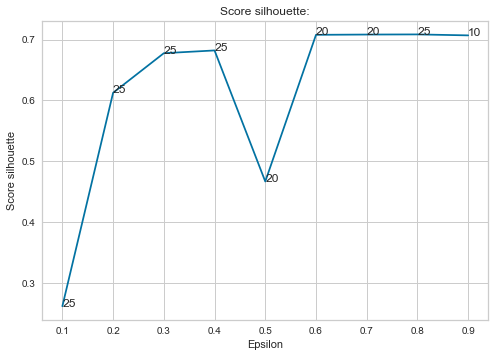

19:56: E128 continuation line under-indented for visual indent


In [89]:
from sklearn import metrics
from tqdm import tqdm

np.random.seed(123)
eps_values = np.arange(0.1, 1, 0.1)
min_samples = np.arange(5, 30, 5)


def dbscan_params(eps_values, min_samples, X_norm):
    silhouette = np.zeros((len(eps_values),
                           len(min_samples)))

    for i in tqdm(range(len(eps_values))):
        for k in range(len(min_samples)):
            db = DBSCAN(eps=eps_values[i],
                        min_samples=min_samples[k])
            db.fit(X_norm)
            silhouette[i, k] = metrics.silhouette_score(X_norm,
                                                        db.labels_)

    max_silhouette = np.max(silhouette, axis=1)
    max_silhouette_idx = np.argmax(silhouette, axis=1)
    best_min_samples = min_samples[max_silhouette_idx]

    if 'eps_values' not in globals():
        eps_values, min_samples,
        silhouette = dbscan_params(eps_values, min_samples, sample)

    plt.plot(eps_values, max_silhouette)
    for i, txt in enumerate(best_min_samples):
        plt.annotate(txt, (eps_values[i], max_silhouette[i]))
    plt.title('Score silhouette:')
    plt.xlabel('Epsilon')
    plt.ylabel('Score silhouette')
    plt.show()

    return eps_values, best_min_samples, max_silhouette


sample = scaled.sample(n=10000, random_state=42)
eps_values, min_samples,
silhouette = dbscan_params(eps_values, min_samples, sample)

D'après notre courbe, on va utiliser eps = 0.6 et min_samples = 20. 

In [381]:
np.random.seed(42)

start_time = time.time()
# Paramètres de DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=20, metric='euclidean')

In [382]:
# Entraîner le modèle DBSCAN
model = dbscan.fit(scaled)
clusters = dbscan.fit_predict(scaled)

# Prédiction des labels des clusters
labels_dbscan = model.labels_

In [383]:
# On calcule le score silhouette pour DBSCAN
silhouette_dbscan = silhouette_score(scaled, labels_dbscan)

In [384]:
# On calcule l'indice de Davies-Bouldin
db_dbscan = davies_bouldin_score(scaled, labels_dbscan)

In [385]:
# On calcule l'indice de Calinski-Harabasz
ch_dbscan = calinski_harabasz_score(scaled, labels_dbscan)

end_time = time.time()
dbscan_time = end_time - start_time

In [386]:
resultat_dbscan = pd.DataFrame(
    {'Silhouette_score': silhouette_dbscan,
     'Davies_bouldin_score': db_dbscan,
     'Calinski_harabasz_score': ch_dbscan,
     'Time': dbscan_time}, index=['DBSCAN'])

resultat_dbscan

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
DBSCAN,0.706218,1.256255,14680.851812,809.184802


In [387]:
# Visualisation des clusters
rfm = rfm[['Récence', 'Fréquence', 'Montant']]
rfm.loc[:, 'Cluster'] = labels_dbscan
rfm.groupby(['Cluster']).mean()

,Récence,Fréquence,Montant
Cluster,,,
-1,293.425926,2.148148,1784.751566
0,238.349019,1.000000,157.065135
1,221.188041,2.000000,139.664025
2,201.460606,3.000000,129.190085


On observe des clusters allant de -1 à 2. Le cluster -1 correspondrait au bruit (outliers) identifiées par DBSCAN. 

In [388]:
# Identification des points considérés comme du bruit
noise_indices = np.where(labels_dbscan == -1)[0]

# Calculer le taux de bruit
taux_bruit = len(noise_indices)/len(rfm)
print("Taux de bruit : {:.2%}".format(taux_bruit))

Taux de bruit : 0.23%


In [389]:
# Créer un dataframe avec les données et les labels de cluster
df_clustered = pd.DataFrame(scaled, columns=rfm.columns)
df_clustered['Cluster'] = clusters

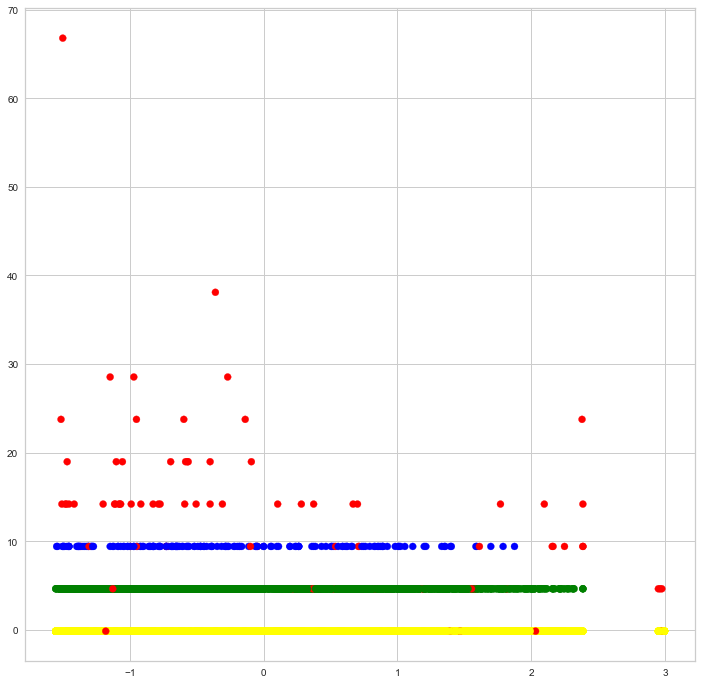

In [390]:
# On regarde les clusters formés par DBSCAN
Cluster_color = {0: u'yellow', 1: u'green',
                 2: u'blue', 3: u'orange',
                 4: u'pink', 5: u'purple', -1: u'red'}
cvec = [Cluster_color[label] for label in labels_dbscan]
plt.figure(figsize=(12, 12))
plt.scatter(df_clustered['Récence'],
            df_clustered['Fréquence'], c=cvec)
plt.show()

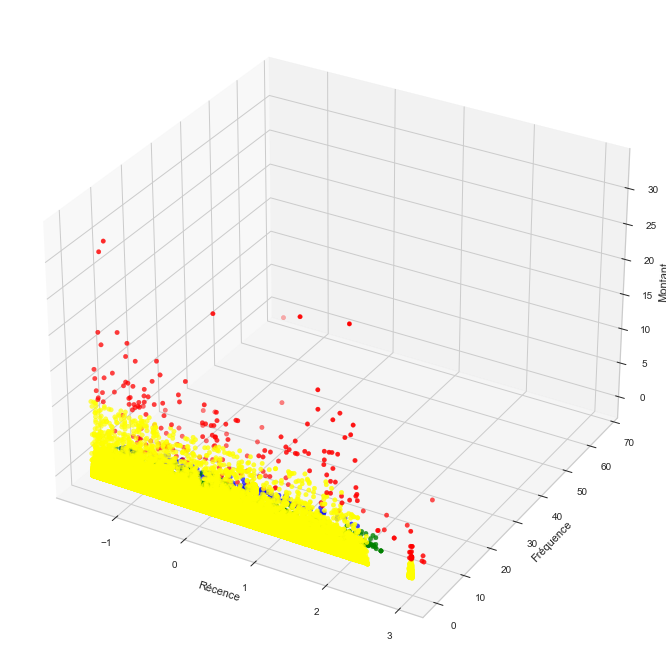

In [391]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_clustered['Récence'], df_clustered['Fréquence'],
           df_clustered['Montant'], c=cvec)
ax.set_xlabel('Récence')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Montant')

plt.show()

In [392]:
# Nombre de clients par cluster
display(rfm['Cluster'].value_counts())

print(round(rfm[
    'Cluster'].value_counts().iloc[0]*100/rfm.shape[0],
            2), '% des clients appartiennent au Cluster 0.')
print(round(rfm[
    'Cluster'].value_counts().iloc[1]*100/rfm.shape[0],
            2), '% des clients appartiennent au Cluster 1.')
print(round(rfm[
    'Cluster'].value_counts().iloc[3]*100/rfm.shape[0],
            2), '% des clients appartiennent au Cluster 2.')

 0    90425
 1     2542
-1      216
 2      165
Name: Cluster, dtype: int64

96.87 % des clients appartiennent au Cluster 0.
2.72 % des clients appartiennent au Cluster 1.
0.18 % des clients appartiennent au Cluster 2.


In [393]:
# On crée une fonction attribuant un critère aux différents clusters


def func(row):
    if row['Cluster'] == 0:
        return 'Clients anciens, dépenses les plus élevées'
    elif row['Cluster'] == 1:
        return 'Clients plus fréquents'
    elif row['Cluster'] == -1:
        return 'Bruit'
    else:
        return 'Clients les plus fréquents et les plus récents'

In [394]:
rfm

,Récence,Fréquence,Montant,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,0
0000f46a3911fa3c0805444483337064,537,1,86.22,0
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,0
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42,0
fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,0
ffff371b4d645b6ecea244b27531430a,568,1,112.46,0


In [395]:
rfm['Clients'] = rfm.apply(func, axis=1)

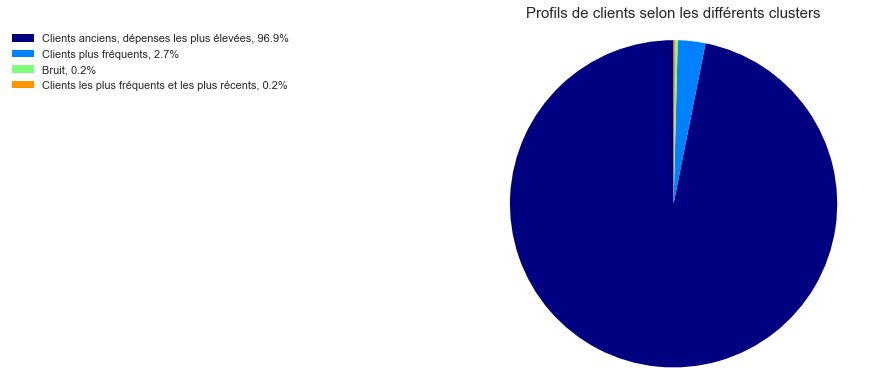

In [396]:
# On trace notre diagramme en camembert selon les différents clusters
pie(rfm, 'Clients', 'Profils de clients selon les différents clusters')

DBSCAN nous identifie 3 clusters :
- **Cluster 0** : clients les moins récents et dont la fréquence d'achat est la plus faible, mais dont le montant dépensé est le plus élevé. 
- **Cluster 1** : clients un peu plus récents, dont la fréquence d'achat est en moyenne de 2 par commande et dont le montant dépensé est plus faible. 
- **Cluster 2** : clients dont les commandes sont les plus récentes, dont la fréquence d'achat est en moyenne de 3 par commande mais dont le montant dépensé par commande est le plus faible. 

On observe que la majorité des clients des clients (97%) appartiennent au même cluster. Les groupes sont **très hétérogènes**. 

De plus, <u>d'un point de vue métier</u>, il serait intéressant d'obtenir plus de groupes et faire ressortir certains clients comme ceux dont les dépenses sont les plus élevées ET dont la fréquence d'achat est supérieure à 1 ET/OU les commandes sont récentes. Ou encore les clients dont les dépenses sont très faibles, peu récents et peu fréquents, ... Profils de clients que l'on observe pas dans nos clusters ici. 

## 1.3) CAH

In [106]:
var = ['Récence', 'Fréquence', 'Montant']
rfm[var].describe()

,Récence,Fréquence,Montant
count,93348.000000,93348.000000,93348.000000
mean,237.943941,1.033423,160.308346
std,152.583287,0.209108,215.250663
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,62.380000
50%,219.000000,1.000000,105.690000
75%,346.000000,1.000000,176.762500
max,695.000000,15.000000,7274.880000


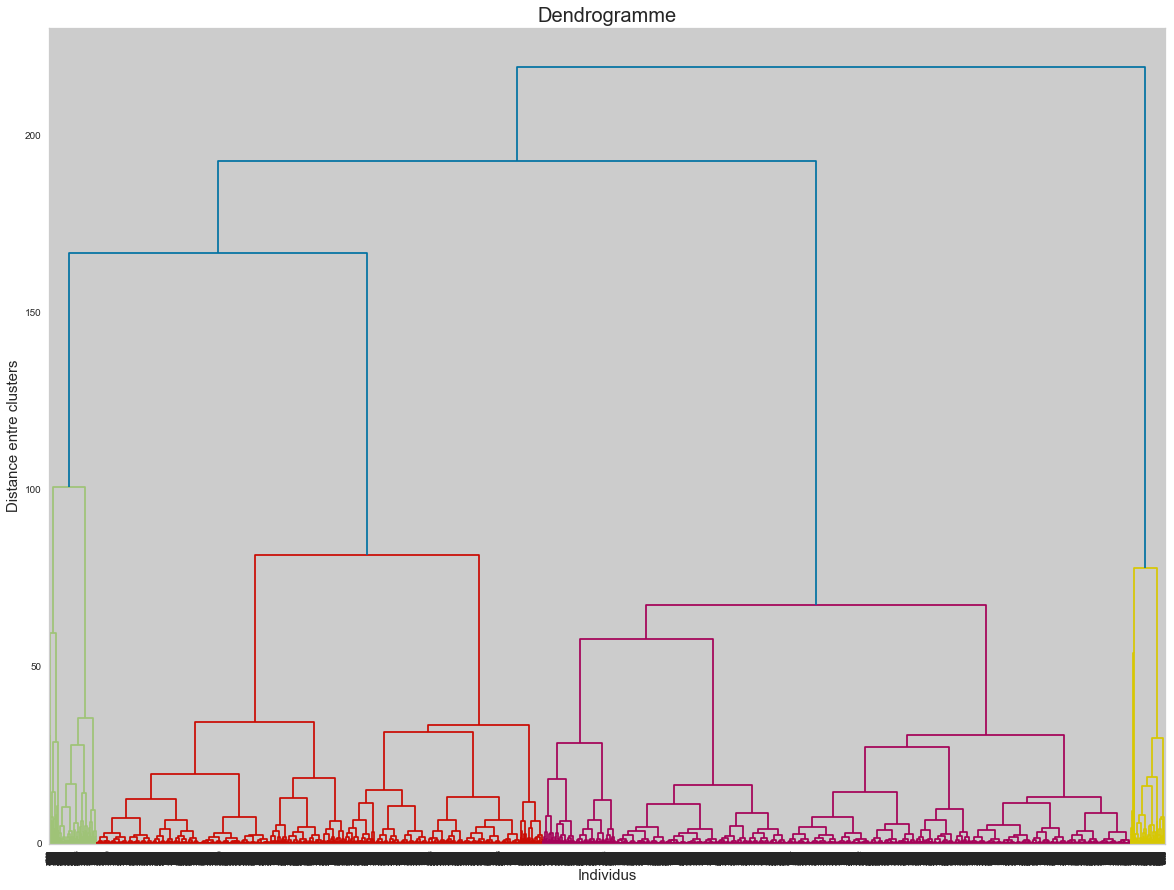

In [107]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Sélection d'un échantillon aléatoire
rfm_cah = scaled.sample(frac=0.3, random_state=42)


# Calcul matrice de liaison
link = linkage(rfm_cah, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(20, 15))
dendrogram(link, orientation='top', distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme', size=20)
plt.xlabel("Individus", size=15)
plt.ylabel("Distance entre clusters", size=15)

plt.show()

Pour la CAH, plus notre jeu de données est grand, plus le temps de chargement pour l'affichage du dendrogramme est long. Nous sommes donc obligé de sélectionner un échantillon aléatoire. 

En observant le dendrogramme, on peut sélectionner le nombre de clusters pour lequel la distance entre les clusters est la plus grande. On peut imaginer sélectionner **4 clusters** pour la suite. 

In [314]:
from sklearn.cluster import AgglomerativeClustering

start_time = time.time()

# On calcule le score silhouette
clustering = AgglomerativeClustering(n_clusters=4).fit(rfm_cah)
silhouette_cah = silhouette_score(rfm_cah, clustering.labels_)

In [315]:
# On calcule le score Davies-Bouldin
model = AgglomerativeClustering(n_clusters=4)
model = model.fit(rfm_cah)
cluster = model.fit_predict(rfm_cah)

davies_bouldin_CAH = davies_bouldin_score(rfm_cah, cluster)

In [316]:
# On calcule le score Calinski-Harabasz
model = AgglomerativeClustering(n_clusters=4)
model = model.fit(rfm_cah)
cluster = model.fit_predict(rfm_cah)

CH_cah = calinski_harabasz_score(rfm_cah, cluster)

end_time = time.time()
CH_time = end_time - start_time

In [317]:
resultat_CAH = pd.DataFrame(
    {'Silhouette_score': silhouette_cah,
     'Davies_bouldin_score': davies_bouldin_CAH,
     'Calinski_harabasz_score': CH_cah,
     'Time': CH_time}, index=['CAH'])

resultat_CAH

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
CAH,0.479362,0.71588,18387.541526,188.249626


Contrairement aux deux autres méthodes de clustering précédentes, pour la CAH il est nécessaire d'effectuer un échantillonnage sur notre jeu de données initial afin d'éviter des messages d'erreurs informant sur le manque de mémoire disponible pour l'AgglomerativeClustering. 

En plus de devoir réduire considérablement notre jeu de données, donc de **perdre de l'information** et prendre le risque que les données ne soient **pas représentives** de notre jeu de données, le **temps de chargement** est relativement long. 

## 1.4) Résumé

In [112]:
# On regroupe les résultats de scores pour nos
# différentes méthodes de clustering
pd.concat([resultat_kmeans, resultat_dbscan, resultat_CAH], axis=0)

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.486856,0.669867,66558.674708,99.187338
DBSCAN,0.706420,1.234585,14846.132632,607.415320
CAH,0.479362,0.715880,18387.541526,178.809870


Si on regarde plus en détail les différentes métriques. 
- <u>**Coefficient de Silhouette**</u> : évalue si un point appartient au bon cluster. 
- <u>**Indice de Davies-Bouldin**</u> : évalue l'homogénéité et la bonne séparation des clusters. 
- <u>**Indice de Calinski-Harabasz**</u> : mesure de la qualité de la partition/compacité des données.

Ces 3 métriques permettent d'évaluer la qualité du clustering. 

<u>Résultats</u> : 

Le meilleur score obtenu pour le Score Silhouette concerne le DBSCAN. Effectivement, nous avons sélectionné les paramètres en se fiant au score silhouette. Néanmoins, concernant l'homogénéité et la bonne séparation des clusters, c'est la méthode Kmeans qui l'emporte sur les autres méthodes. Il en est de même pour l'indice de Calinski-Harabasz où la méthode de Kmeans a une valeur bien au-dessus des autres méthodes. 

On peut donc retenir, pour la **méthode du Kmeans** (plus rapide, meilleure qualité de clustering) comme modèle. 

# 2) Classification RFM + nombre articles + satisfaction

In [113]:
# On effectue un groupby() pour garder nos variables
# (nombre articles moyen par client/commande et
# note de satisfaction moyenne par client/commande)

nbarticles_note = df.groupby(
    'customer_unique_id')[['Note_moyenne',
                           'Nombre_articles']].mean().reset_index()

rfm = rfm[['Récence', 'Fréquence', 'Montant']]

data = pd.merge(rfm, nbarticles_note, on='customer_unique_id', how='left')

In [114]:
data = data.set_index('customer_unique_id')

<Axes: >

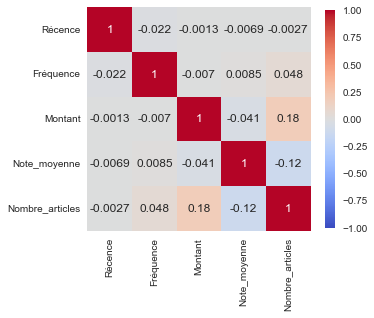

In [115]:
# Corrélation entre les variables

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data.corr(), annot=True, square=True, vmin=-1, vmax=+1,
            cmap=plt.colormaps.get_cmap('coolwarm'),
            cbar_kws={"shrink": 0.8})

## 2.1) Kmeans

In [116]:
# Standardisation des données
from sklearn.preprocessing import StandardScaler

col = data.columns.tolist()

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data[col]), columns=col)

Pour la sélection du nombre de clusters optimal, nous allons utiliser la **méthode du coude**. 

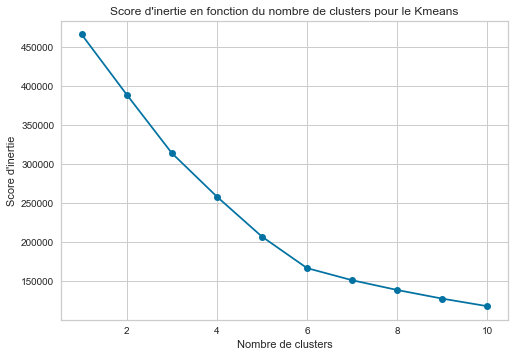

In [117]:
# On trace la courbe du score d'inertie à partir de notre fonction
score_inertie(data_scaled)

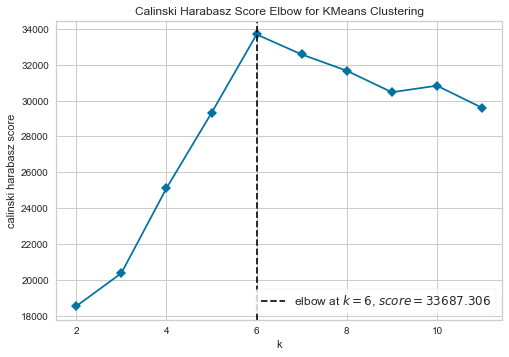

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

2:36: W291 trailing whitespace


In [118]:
# Calcul des scores de Calinski Harabasz
# en fonction du nombre de clusters 
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 12), metric='calinski_harabasz', timings=False
)

visualizer.fit(data_scaled)
visualizer.show()

D'après les résultats pour notre méthode du coude et le score de Calinski Harabasz, le nombre de clusters optimal est de **6**. 

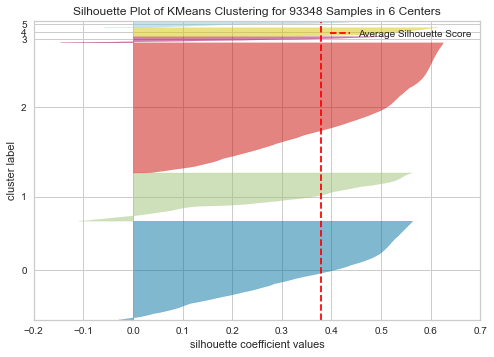

1:71: W291 trailing whitespace


In [119]:
# Observons avec SilhouetteVisualizer la qualité de la clusterisation. 
from yellowbrick.cluster import SilhouetteVisualizer

K = [6]

# Initialisation de l'algorithme KMeans avec différents nombres de clusters
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(data_scaled)
    visualizer.show()

### Pour k = 6

In [120]:
np.random.seed(42)

# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=6)
kmeans.fit(data_scaled)
data['Clusters'] = (kmeans.labels_ + 1)

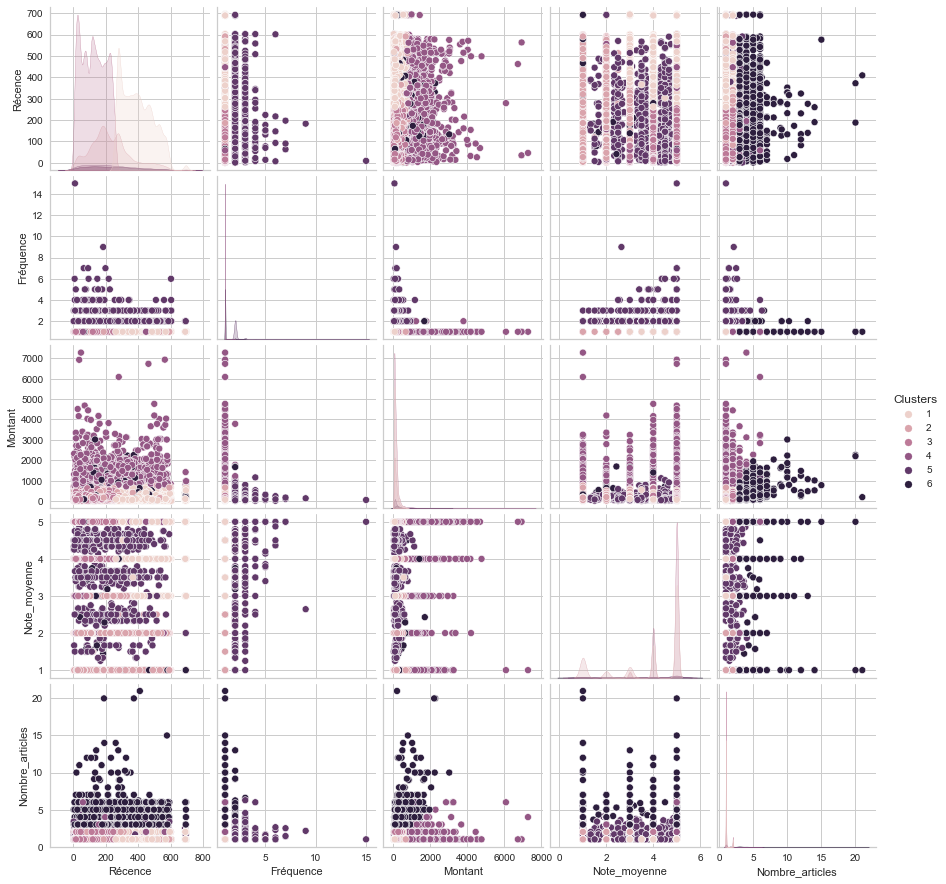

In [121]:
# Visualisation graphique de nos clusters
sns.pairplot(data, hue="Clusters")

In [122]:
# On regroupe nos clusters en calculant leur
# médiane pour chaque variable
group_mediane = data.groupby(
    ['Clusters'])[['Récence', 'Fréquence', 'Montant',
                   'Note_moyenne', 'Nombre_articles']].median()
group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant,Note_moyenne,Nombre_articles
Clusters,,,,,
1,384.000000,1.000000,98.220000,5.000000,1.000000
2,211.000000,1.000000,108.290000,1.000000,1.000000
3,121.000000,1.000000,100.350000,5.000000,1.000000
4,219.000000,1.000000,1014.800000,5.000000,1.000000
5,200.000000,2.000000,110.049167,4.750000,1.000000
6,216.000000,1.000000,240.040000,4.000000,3.000000


Interprétation des différents clusters : 
- **Cluster 1** : clients ayant effectué un seul achat, à montant faible, il y a plus d'un an mais dont la satisfaction est très bonne.
- **Cluster 2** : clients très satisfaits, ayant acheté récemment, mais dont le montant reste faible. 
- **Cluster 3** : clients pas du tout satisfaits, dont les dépenses sont assez faibles, n'ayant acheté qu'une seule fois. 
- **Cluster 4** : clients achetant plusieurs articles par commande, plutôt satisfaits et dont les montants sont plus élevés. 
- **Cluster 5** : clients très satisfaits ayant acheté 1 article par commande, mais dont les dépenses sont les plus élevées. 
- **Cluster 6** : clients plutôt satisfaits, achetant à une plus grande fréquence. 

In [123]:
def func(row):
    if row['Clusters'] == 1:
        return 'Anciens clients très satisfaits, dépenses faibles'
    elif row['Clusters'] == 2:
        return 'Récents clients très satisfaits, dépenses faibles'
    elif row['Clusters'] == 4:
        return ('Clients assez satisfaits, bonnes dépenses, '
                'plusieurs articles par commande')
    elif row['Clusters'] == 5:
        return 'Clients très satisfaits, dépenses les plus fortes'
    elif row['Clusters'] == 6:
        return 'Clients assez satisfaits, achetant fréquemment'
    else:
        return 'Clients non satisfaits, dépenses faibles'

In [124]:
data['Clients'] = data.apply(func, axis=1)

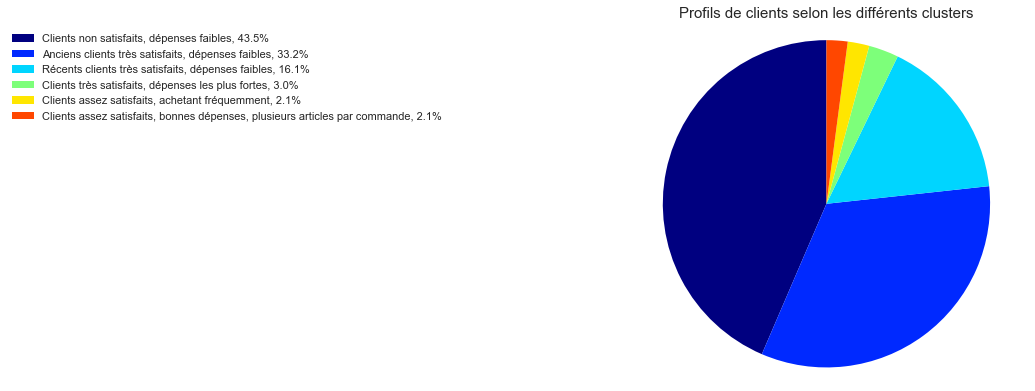

In [125]:
# On trace notre diagramme en camembert selon les différents clusters
pie(data, 'Clients', 'Profils de clients selon les différents clusters')

In [126]:
# Création d'une nouvelle fonction prenant en compte 5 variables

def trans_var_5(var1, var2, var3, var4, var5, df):
    # On sélectionne les variables à utiliser
    var = [var1, var2, var3, var4, var5]

    # On met à l'échelle de 0 à 100
    new_max = 100
    new_min = 0
    new_range = new_max - new_min

    # Transformation linéaire pour chaque variable
    for factor in var:
        max_val = group_mediane[factor].max()
        min_val = group_mediane[factor].min()
        val_range = max_val - min_val
        df[factor+'_Adj'] = df[factor].apply(
          lambda x: (((x - min_val)*new_range)/val_range)+new_min)
    return df

In [127]:
# Création d'une nouvelle fonction affichant la carte radar multiple

def radar_chart_5(new_var1, new_var2, new_var3, new_var4, new_var5, new_df):
    var = [new_var1, new_var2, new_var3, new_var4, new_var5]

    fig = go.Figure()

    for i in range(1, new_df.shape[0]+1):
        fig.add_trace(go.Scatterpolar(
          r=new_df.loc[i, var].tolist(),
          theta=var,
          fill='toself',
          name=i
        ))
    fig.show()

In [128]:
# Création de nos nouvelles variables mises à l'échelle
radar_6 = trans_var_5('Récence', 'Fréquence', 'Montant',
                      'Nombre_articles', 'Note_moyenne', group_mediane)

In [129]:
# On renomme nos nouvelles colonnes
radar_6 = radar_6.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes',
                                  'Nombre_articles_Adj': 'Nombre_articles',
                                  'Note_moyenne_Adj': 'Note_moyenne'})
radar_6 = radar_6.iloc[:, 5:10]

In [130]:
# On affiche notre carte radar
radar_chart_5('Commandes_récentes', 'Nombre_commandes',
              'Dépenses_commandes', 'Nombre_articles', 'Note_moyenne', radar_6)

On observe une majorité de clients ayant effectué des achats récents et étant très satisfaits (43.6%). 

<u>D'un point de vue métier</u>, il peut être intéressant de connaître cette information de satisfaction, associé au fait que le client ai acheté récemment en supposant que ce client puisse revenir. 

33.1% des clients sont ancients (> 1 an en moyenne), mais ont été très satisfaits de leur commande, il peut être possible de les relancer (newsletter) proposant des produits similaires à leurs achats. 

Pour les 16% de clients non satisfaits, il peut être intéressant de regarder les enquêtes de satisfaction et faire du cas par cas. 

### a) Catégories produits clients anciens (cluster 1)

In [131]:
# On sélectionne les colonnes qui nous intéressent
col = ['customer_unique_id', 'product_category_name_english',
       'categorie_commune', 'Avis_laissé']

# On merge notre fichier data avec le fichier de base
merge = pd.merge(data, df[col], on='customer_unique_id', how='left')

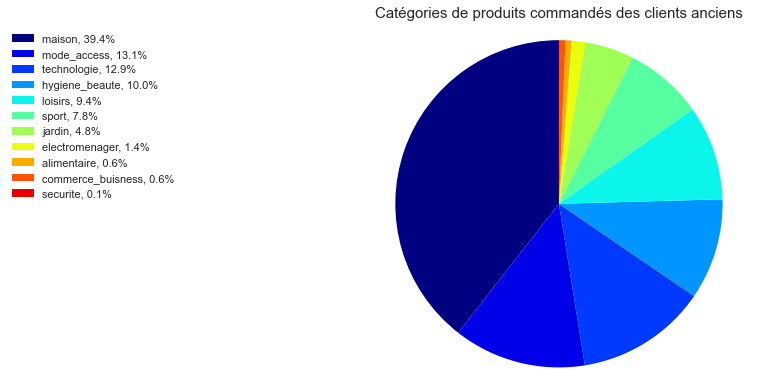

In [132]:
# On regarde uniquement pour les clients anciens (cluster 1)
clust1 = merge[merge['Clusters'] == 1]

# On trace notre diagramme en camembert des catégories
# de produits achetés pour les clients anciens (cluster 1)
pie(clust1, 'categorie_commune',
    'Catégories de produits commandés des clients anciens')

In [133]:
# Regardons parmis les différentes catégories de base
(clust1[
    'product_category_name_english'].value_counts()*100/clust1.shape[
    0]).head(10)

bed_bath_table           11.358063
furniture_decor           7.957432
sports_leisure            7.609267
health_beauty             6.431199
housewares                6.407112
computers_accessories     5.539984
cool_stuff                5.021021
toys                      4.863362
garden_tools              4.541473
telephony                 4.096961
Name: product_category_name_english, dtype: float64

### b) Commentaires laissés clients non satisfaits

In [134]:
# On regarde uniquement pour les clients non satisfaits (cluster 3)
clust3 = merge[merge['Clusters'] == 3]
clust3

(clust3['Avis_laissé'].value_counts(normalize=True)*100)

0    66.871097
1    33.128903
Name: Avis_laissé, dtype: float64

In [135]:
# Regardons les commentaires laissés pour la totalité des clients
merge['Avis_laissé'].value_counts(normalize=True)*100

0    57.354273
1    42.645727
Name: Avis_laissé, dtype: float64

On observe effectivement que, pour ce groupe, 66% des clients ont laissé un avis. Tandis que lorsqu'on se focalise sur la totalité des clients, 43% d'entre eux ont laissé un avis. Comme préconisé, l'idée serait de traiter au cas par cas ces différents clients.

### Calcul scores

In [136]:
import time

start_time = time.time()

# On applique le KMeans sur nos données standardisées
kmeans = KMeans(n_init=10, n_clusters=6)
kmeans.fit(data_scaled)
# On prédit les clusters pour chaque observation,
# puis on les stocke dans la variable "labels"
labels_kmeans = kmeans.predict(data_scaled)

In [137]:
# On calcule le score silhouette
silhouette_kmeans = silhouette_score(data_scaled, labels_kmeans)

In [138]:
# On calcule l'indice de Davies-Bouldin
db_kmeans = davies_bouldin_score(data_scaled, labels_kmeans)

In [139]:
# On calcule l'indice de Calinski-Harabasz
ch_kmeans = calinski_harabasz_score(data_scaled, labels_kmeans)

end_time = time.time()
kmeans_time = end_time - start_time

In [140]:
resultat_kmeans = pd.DataFrame(
    {'Silhouette_score': silhouette_kmeans,
     'Davies_bouldin_score': db_kmeans,
     'Calinski_harabasz_score': ch_kmeans,
     'Time': kmeans_time}, index=['Kmeans'])

resultat_kmeans

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.379887,0.859545,33687.309445,95.735505


## 2.2) DBSCAN

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:38<00:00, 10.89s/it]


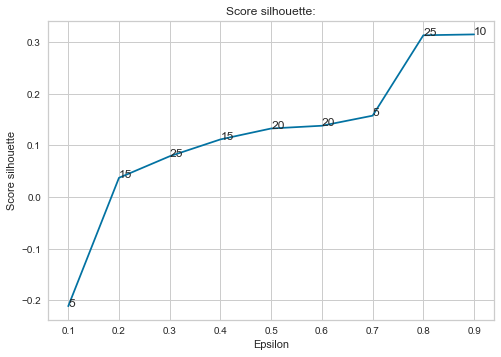

In [141]:
# On cherche les paramètres optimaux pour DBSCAN

np.random.seed(42)

sample = data_scaled.sample(n=10000, random_state=42)
eps_values, min_samples, silhouette = dbscan_params(eps_values,
                                                    min_samples, sample)

In [142]:
np.random.seed(42)

start_time = time.time()

# Paramètres de DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=25, metric='euclidean')

In [143]:
# Entraîner le modèle DBSCAN
model = dbscan.fit(data_scaled)
clusters = dbscan.fit_predict(data_scaled)

# Prédiction des labels des clusters
labels_dbscan = model.labels_

In [144]:
# On calcule le score silhouette pour DBSCAN
silhouette_dbscan = silhouette_score(data_scaled, labels_dbscan)

In [145]:
# On calcule l'indice de Davies-Bouldin
db_dbscan = davies_bouldin_score(data_scaled, labels_dbscan)

In [146]:
# On calcule l'indice de Calinski-Harabasz
ch_dbscan = calinski_harabasz_score(data_scaled, labels_dbscan)

end_time = time.time()
dbscan_time = end_time - start_time

In [147]:
resultat_dbscan = pd.DataFrame(
    {'Silhouette_score': silhouette_dbscan,
     'Davies_bouldin_score': db_dbscan,
     'Calinski_harabasz_score': ch_dbscan,
     'Time': dbscan_time}, index=['DBSCAN'])

resultat_dbscan

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
DBSCAN,0.325657,1.627073,5706.073236,230.904268


In [148]:
# Visualisation des clusters
data_dbscan = data[['Récence', 'Fréquence', 'Montant',
                    'Note_moyenne', 'Nombre_articles']]
data_dbscan.loc[:, 'Cluster'] = labels_dbscan
data_dbscan.groupby(['Cluster']).median()

,Récence,Fréquence,Montant,Note_moyenne,Nombre_articles
Cluster,,,,,
-1,230.0,1.0,608.526667,4.0,3.0
0,219.0,1.0,99.060000,5.0,1.0
1,220.0,1.0,153.320000,4.0,2.0
2,197.5,1.0,206.180000,5.0,4.0
3,201.0,2.0,103.115000,5.0,1.0
4,216.0,1.0,196.680000,4.0,3.0
5,178.5,3.0,92.785000,5.0,1.0
6,222.5,1.0,264.065000,1.0,4.0
7,77.0,2.0,180.157250,5.0,2.5


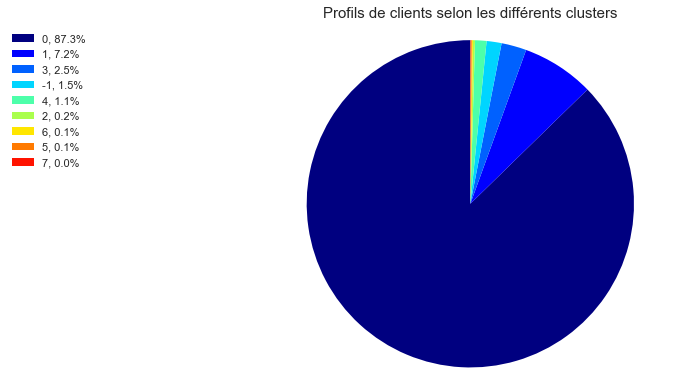

In [149]:
# On trace notre diagramme en camembert selon les différents clusters
pie(data_dbscan, 'Cluster', 'Profils de clients selon les différents clusters')

In [150]:
# Identification des points considérés comme du bruit
noise_indices = np.where(labels_dbscan == -1)[0]

# Calculer le taux de bruit
taux_bruit = len(noise_indices) / len(data_scaled)
print("Taux de bruit : {:.2%}".format(taux_bruit))

Taux de bruit : 1.48%


Plusieurs clusters sont identifiés. Néanmoins, les groupes restent à nouveau très **hétérogènes**, avec un groupe qui domine largement sur le reste. 

## 2.3) CAH 

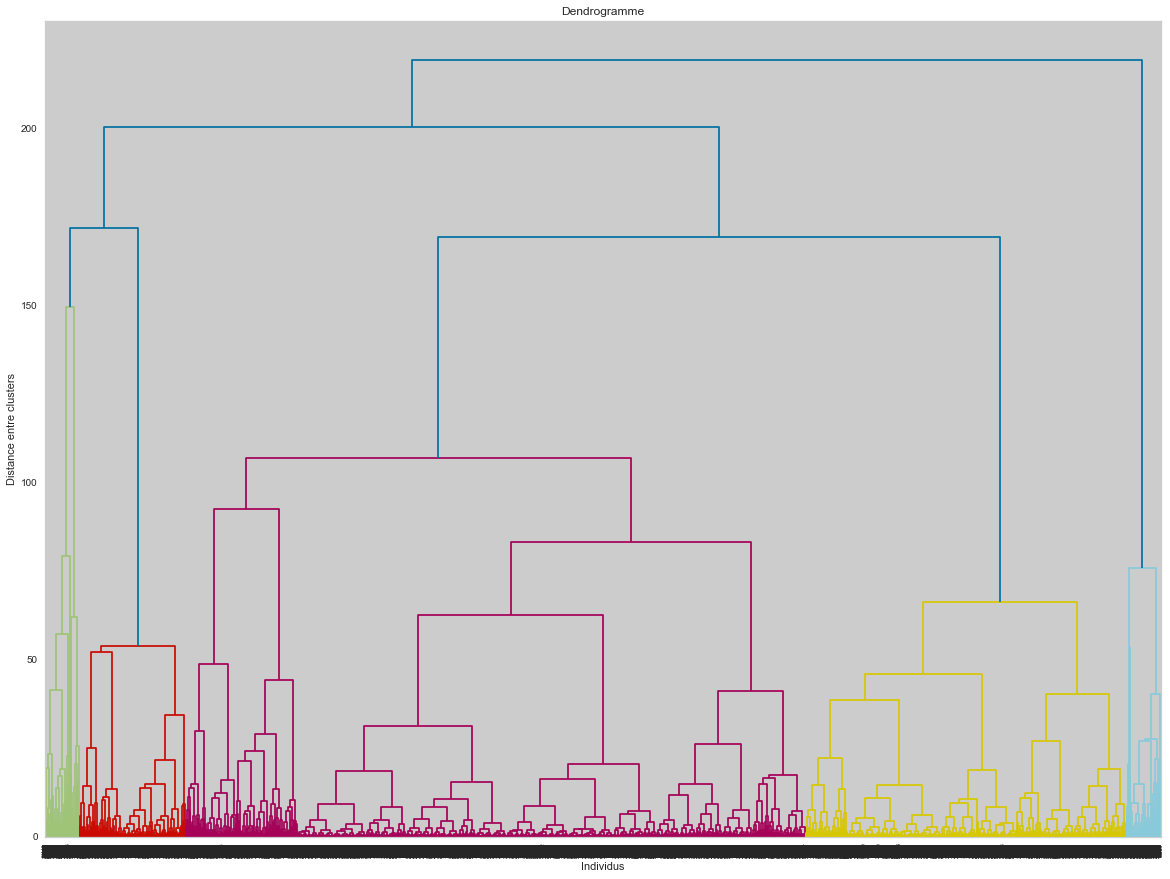

In [151]:
# Sélection d'un échantillon aléatoire
data_cah = data_scaled.sample(frac=0.3, random_state=42)

# Calcul matrice de liaison
link = linkage(data_cah, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(20, 15))
dendrogram(link, orientation='top', distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme')
plt.xlabel("Individus")
plt.ylabel("Distance entre clusters")

plt.show()

In [152]:
from sklearn.cluster import AgglomerativeClustering

start_time = time.time()

# On calcule le score silhouette
clustering = AgglomerativeClustering(n_clusters=5).fit(data_cah)
silhouette_cah = silhouette_score(data_cah, clustering.labels_)

In [153]:
# On calcule le score Davies-Bouldin
model = AgglomerativeClustering(n_clusters=5)
model = model.fit(data_cah)
cluster = model.fit_predict(data_cah)

davies_bouldin_CAH = davies_bouldin_score(data_cah, cluster)

In [154]:
# On calcule le score Calinski-Harabasz
model = AgglomerativeClustering(n_clusters=5)
model = model.fit(data_cah)
cluster = model.fit_predict(data_cah)

CH_cah = calinski_harabasz_score(data_cah, cluster)

end_time = time.time()
CH_time = end_time - start_time

In [155]:
resultat_CAH = pd.DataFrame(
    {'Silhouette_score': silhouette_cah,
     'Davies_bouldin_score': davies_bouldin_CAH,
     'Calinski_harabasz_score': CH_cah,
     'Time': CH_time}, index=['CAH'])

resultat_CAH

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
CAH,0.315745,1.131342,7447.428902,194.897672


In [156]:
# On regroupe les résultats de scores pour
# nos différentes méthodes de clustering
pd.concat([resultat_kmeans, resultat_dbscan, resultat_CAH], axis=0)

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.379887,0.859545,33687.309445,95.735505
DBSCAN,0.325657,1.627073,5706.073236,230.904268
CAH,0.315745,1.131342,7447.428902,194.897672


D'après les scores obtenus, on observe que la méthode du **Kmeans** est la plus intéressante. 

# 3) Classification RFM + nombre articles + satisfaction + nombre versements

In [157]:
# On effectue un groupby() pour garder nos variables
# (nombre articles moyen par client/commande,
# note de satisfaction moyenne par client/commande
# et nombre de paiements par commande)

nb_versements = df.groupby(
    'customer_unique_id')['payment_installments'].mean().reset_index()
data = data.reset_index()
data = data[['customer_unique_id', 'Récence', 'Fréquence',
             'Montant', 'Note_moyenne', 'Nombre_articles']]

data_2 = pd.merge(data, nb_versements, on='customer_unique_id',
                  how='left').set_index('customer_unique_id')

<Axes: >

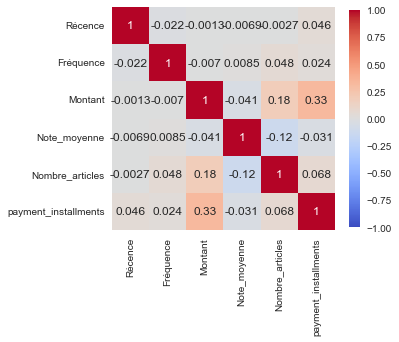

In [158]:
# Corrélation entre les variables

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data_2.corr(), annot=True, square=True, vmin=-1, vmax=+1,
            cmap=plt.colormaps.get_cmap('coolwarm'),
            cbar_kws={"shrink": 0.8})

On observe une très légère corrélation (0.33) entre le montant et le nombre de virements effectué. 

## 3.1) Kmeans

In [159]:
# Standardisation des données
from sklearn.preprocessing import StandardScaler

col = data_2.columns.tolist()

scaler = StandardScaler()
data_2_scaled = pd.DataFrame(scaler.fit_transform(data_2[col]),
                             columns=col)

Pour la sélection du nombre de clusters optimal, nous allons utiliser la **méthode du coude**.

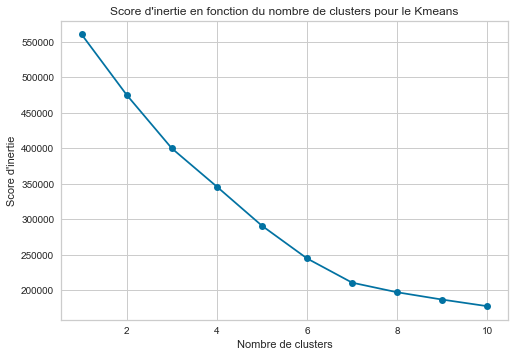

In [160]:
# On trace la courbe du score d'inertie à partir de notre fonction
score_inertie(data_2_scaled)

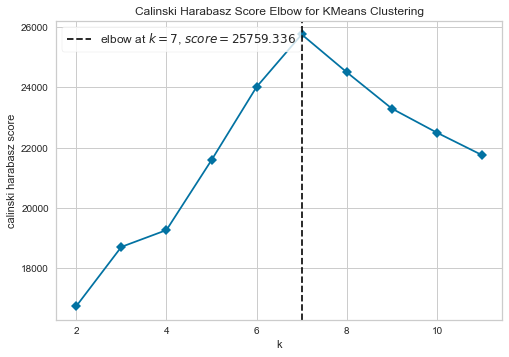

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [161]:
# Calcul des scores de Calinski Harabasz
# en fonction du nombre de clusters
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 12), metric='calinski_harabasz', timings=False
)

visualizer.fit(data_2_scaled)
visualizer.show()

D'après les résultats pour notre méthode du coude et le score de Calinski Harabasz, le nombre de clusters optimal est de **7**.

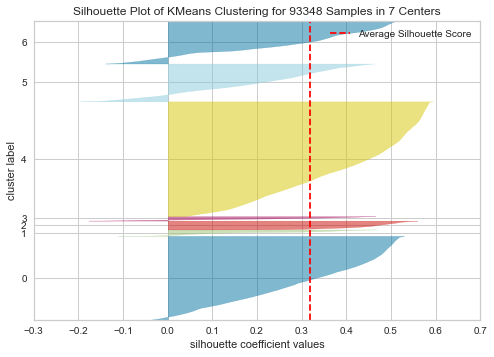

In [162]:
# Observons avec SilhouetteVisualizer la qualité de la clusterisation
from yellowbrick.cluster import SilhouetteVisualizer

K = [7]

# Initialisation de l'algorithme KMeans avec différents nombres de clusters
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(data_2_scaled)
    visualizer.show()

### Pour k = 7

In [163]:
np.random.seed(42)

# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=7)
kmeans.fit(data_2_scaled)
data_2['Clusters'] = (kmeans.labels_ + 1)

In [164]:
# On regroupe nos clusters en calculant leur
# médiane pour chaque variable
group_mediane = data_2.groupby(['Clusters'])[col].median()
group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant,Note_moyenne,Nombre_articles,payment_installments
Clusters,,,,,,
1,387.000000,1.000000,86.790000,5.000000,1.000000,1.000000
2,216.000000,1.000000,240.030000,4.000000,3.000000,2.000000
3,200.000000,2.000000,110.053333,4.750000,1.000000,2.333333
4,211.000000,1.000000,1220.000000,5.000000,1.000000,8.000000
5,120.000000,1.000000,90.880000,5.000000,1.000000,1.000000
6,237.000000,1.000000,192.530000,5.000000,1.000000,8.000000
7,212.000000,1.000000,103.115000,1.000000,1.000000,1.000000


Interprétation des différents clusters : 
- **Cluster 1** : anciens clients ayant effectué un seul achat, à montant faible, très satisfaits. 
- **Cluster 2** : clients très satisfaits, avec de bonnes dépenses, effectuant en moyenne 8 virements par achat. 
- **Cluster 3** : clients assez satisfaits, avec de bonnes dépenses achetant en moyenne 3 articles par commande. 
- **Cluster 4** : clients ayant commandé plus d'une fois, plutôt satisfaits. 
- **Cluster 5** : clients les plus récents, dont les dépenses sont assez basses. 
- **Cluster 6** : clients non satisfaits, dépenses assez faibles. 
- **Cluster 7** : clients satisfaits, dont les dépenses sont les plus élevées, effectuant plusieurs virements. 

In [165]:
def func(row):
    if row['Clusters'] == 1:
        return 'Anciens clients très satisfaits, dépenses faibles'
    elif row['Clusters'] == 2:
        return 'Clients très satisfaits, effectuant de nombreux virements'
    elif row['Clusters'] == 3:
        return ('Clients assez satisfaits, bonnes dépenses, '
                'plusieurs articles par commande')
    elif row['Clusters'] == 4:
        return ('Clients satisfaits, achetant plus fréquemment '
                'et effectuant quelques virement')
    elif row['Clusters'] == 5:
        return 'Clients les plus récents, très satisfaits, dépenses faibles'
    elif row['Clusters'] == 6:
        return 'Clients non satisfaits'
    else:
        return ('Clients très satisfaits, très fortes dépenses, '
                'nombreux virements')

In [166]:
data_2['Clients'] = data_2.apply(func, axis=1)

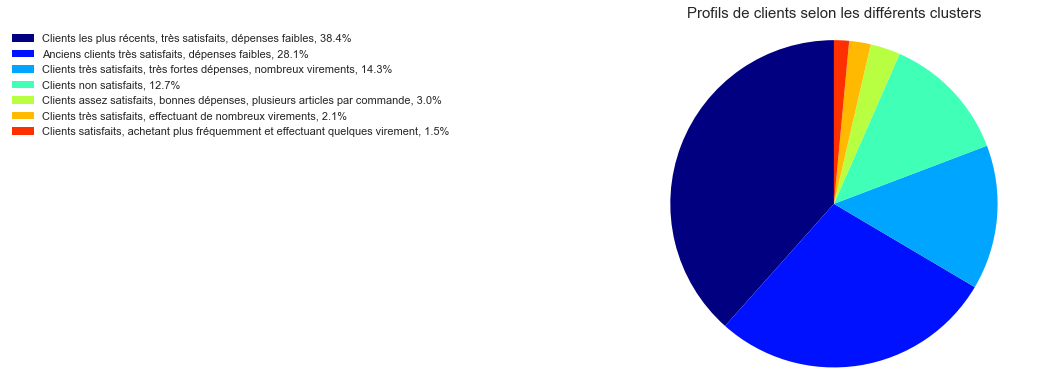

In [167]:
# On trace notre diagramme en camembert selon les différents clusters
pie(data_2, 'Clients', 'Profils de clients selon les différents clusters')

In [168]:
# Création d'une nouvelle fonction prenant en compte 5 variables

def trans_var_6(var1, var2, var3, var4, var5, var6, df):
    # On sélectionne les variables à utiliser
    var = [var1, var2, var3, var4, var5, var6]

    # On met à l'échelle de 0 à 100
    new_max = 100
    new_min = 0
    new_range = new_max - new_min

    # Transformation linéaire pour chaque variable
    for factor in var:
        max_val = group_mediane[factor].max()
        min_val = group_mediane[factor].min()
        val_range = max_val - min_val
        df[factor + '_Adj'] = df[factor].apply(
          lambda x: (((x-min_val)*new_range)/val_range)+new_min)
    return df

In [169]:
# Création d'une nouvelle fonction affichant la carte radar multiple

def radar_chart_6(new_var1, new_var2, new_var3, new_var4,
                  new_var5, new_var6, new_df):
    var = [new_var1, new_var2, new_var3, new_var4, new_var5, new_var6]

    fig = go.Figure()

    for i in range(1, new_df.shape[0] + 1):
        fig.add_trace(go.Scatterpolar(
          r=new_df.loc[i, var].tolist(),
          theta=var,
          fill='toself',
          name=i
        ))
    fig.show()

In [170]:
# Création de nos nouvelles variables mises à l'échelle
radar_7 = trans_var_6('Récence', 'Fréquence', 'Montant', 'Nombre_articles',
                      'Note_moyenne', 'payment_installments', group_mediane)

In [171]:
# On renomme nos nouvelles colonnes
radar_7 = radar_7.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes',
                                  'Nombre_articles_Adj': 'Nombre_articles',
                                  'Note_moyenne_Adj': 'Note_moyenne',
                                  'payment_installments_Adj':
                                  'Nombre_virements'})
radar_7 = radar_7.iloc[:, 6:12]

In [172]:
# On affiche notre carte radar
radar_chart_6('Commandes_récentes', 'Nombre_commandes', 'Dépenses_commandes',
              'Nombre_articles', 'Note_moyenne', 'Nombre_virements', radar_7)

In [173]:
import time

start_time = time.time()

# On applique le KMeans sur nos données standardisées
kmeans = KMeans(n_init=10, n_clusters=7)
kmeans.fit(data_2_scaled)

# On prédit les clusters pour chaque observation,
# puis on les stocke dans la variable "labels"
labels_kmeans = kmeans.predict(data_2_scaled)

In [174]:
# On calcule le score silhouette
silhouette_kmeans = silhouette_score(data_2_scaled, labels_kmeans)

In [175]:
# On calcule l'indice de Davies-Bouldin
db_kmeans = davies_bouldin_score(data_2_scaled, labels_kmeans)

In [176]:
# On calcule l'indice de Calinski-Harabasz
ch_kmeans = calinski_harabasz_score(data_2_scaled, labels_kmeans)

end_time = time.time()
kmeans_time = end_time - start_time

In [177]:
resultat_kmeans = pd.DataFrame(
    {'Silhouette_score': silhouette_kmeans,
     'Davies_bouldin_score': db_kmeans,
     'Calinski_harabasz_score': ch_kmeans,
     'Time': kmeans_time}, index=['Kmeans'])

resultat_kmeans

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.319209,0.952285,25759.334671,98.686237


## 3.2) DBSCAN

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:05<00:00, 20.60s/it]


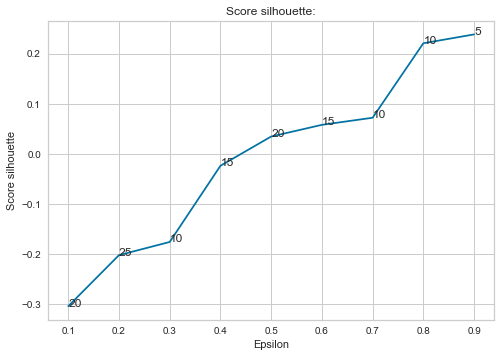

6:80: E501 line too long (84 > 79 characters)


In [178]:
# On cherche les paramètres optimaux pour DBSCAN

np.random.seed(42)

sample = data_2_scaled.sample(n=10000, random_state=42)
eps_values, min_samples, silhouette = dbscan_params(eps_values, min_samples, sample)

In [179]:
np.random.seed(42)

start_time = time.time()

# Paramètres de DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=15, metric='euclidean')

In [180]:
# Entraîner le modèle DBSCAN
model = dbscan.fit(data_2_scaled)
clusters = dbscan.fit_predict(data_2_scaled)

# Prédiction des labels des clusters
labels_dbscan = model.labels_

In [181]:
# On calcule le score silhouette pour DBSCAN
silhouette_dbscan = silhouette_score(data_2_scaled, labels_dbscan)

In [182]:
# On calcule l'indice de Davies-Bouldin
db_dbscan = davies_bouldin_score(data_2_scaled, labels_dbscan)

In [183]:
# On calcule l'indice de Calinski-Harabasz
ch_dbscan = calinski_harabasz_score(data_2_scaled, labels_dbscan)

end_time = time.time()
dbscan_time = end_time - start_time

In [184]:
resultat_dbscan = pd.DataFrame(
    {'Silhouette_score': silhouette_dbscan,
     'Davies_bouldin_score': db_dbscan,
     'Calinski_harabasz_score': ch_dbscan,
     'Time': dbscan_time}, index=['DBSCAN'])

resultat_dbscan

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
DBSCAN,0.260097,1.610259,3282.872838,266.715016


In [185]:
# Visualisation des clusters
data_dbscan = data_2[['Récence', 'Fréquence', 'Montant', 'Note_moyenne',
                      'Nombre_articles', 'payment_installments']]
data_dbscan.loc[:, 'Cluster'] = labels_dbscan
data_dbscan.groupby(['Cluster']).median().style.bar(
    subset=['Récence', 'Fréquence', 'Montant', 'Note_moyenne',
            'Nombre_articles', 'payment_installments'])

,Récence,Fréquence,Montant,Note_moyenne,Nombre_articles,payment_installments
Cluster,,,,,,
-1,252.000000,1.000000,481.940000,4.000000,2.000000,5.500000
0,219.000000,1.000000,98.620000,5.000000,1.000000,2.000000
1,219.000000,1.000000,151.790000,4.000000,2.000000,2.000000
2,163.500000,1.000000,203.720000,5.000000,4.000000,1.000000
3,198.000000,2.000000,99.690000,5.000000,1.000000,2.000000
4,209.000000,1.000000,189.240000,5.000000,3.000000,2.000000
5,153.000000,3.000000,74.090909,5.000000,1.000000,1.000000
6,208.500000,1.000000,214.115000,1.000000,4.000000,1.000000
7,80.000000,1.000000,256.500000,5.000000,6.000000,1.000000


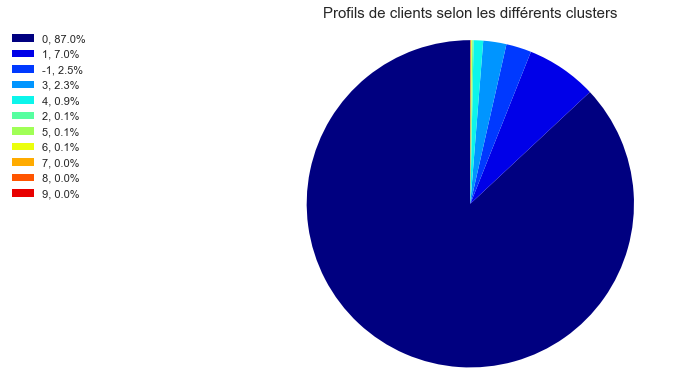

In [186]:
# On trace notre diagramme en camembert selon les différents clusters
pie(data_dbscan, 'Cluster', 'Profils de clients selon les différents clusters')

10 clusters sont identifiés dont un contenant du bruit (2.5% des données). Néanmoins, un cluster reste toujours majoritaire (87% des données) et le reste ne représente qu'une infime partie des données. Donc, clusters toujours **très hétérogènes**. 

## 3.3) CAH

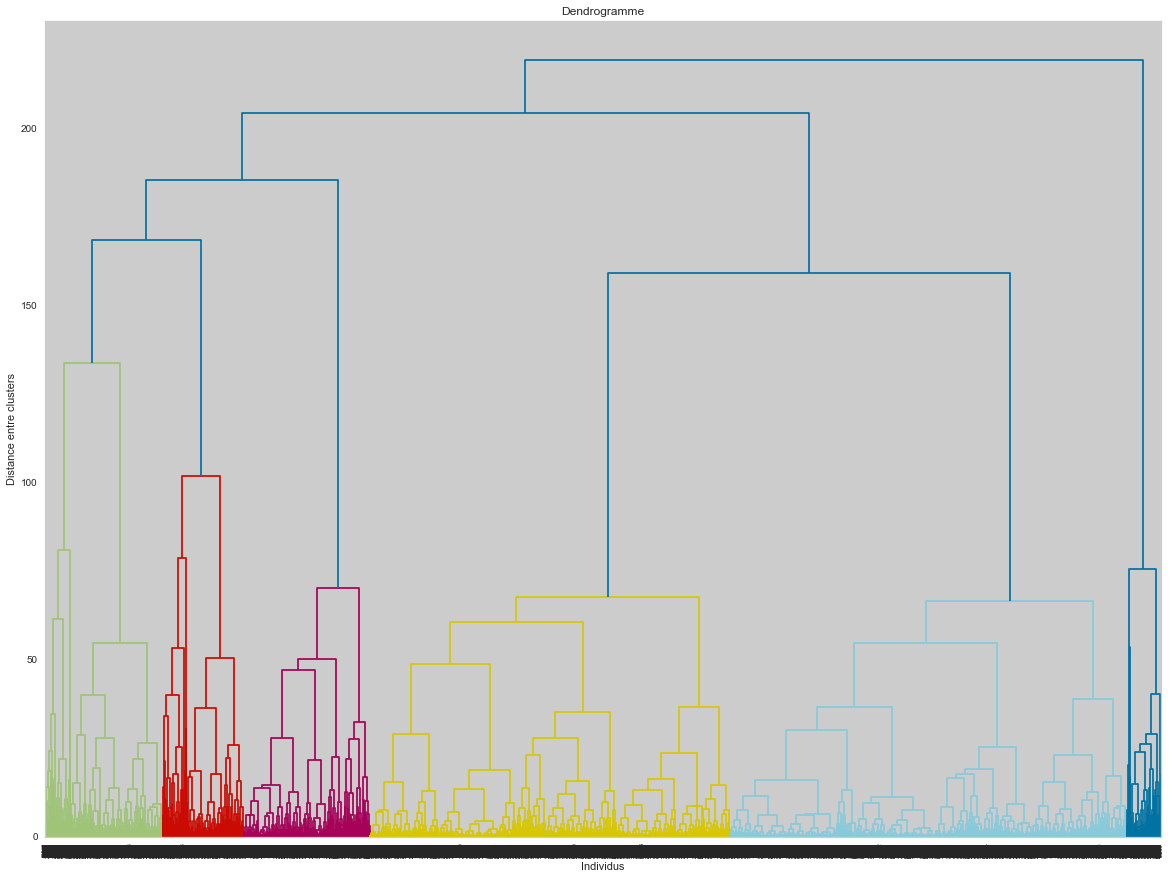

In [187]:
# Sélection d'un échantillon aléatoire
data_cah_2 = data_2_scaled.sample(frac=0.3, random_state=42)

# Calcul matrice de liaison
link = linkage(data_cah_2, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(20, 15))
dendrogram(link, orientation='top', distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme')
plt.xlabel("Individus")
plt.ylabel("Distance entre clusters")

plt.show()

In [188]:
from sklearn.cluster import AgglomerativeClustering

start_time = time.time()

# On calcule le score silhouette
clustering = AgglomerativeClustering(n_clusters=6).fit(data_cah_2)
silhouette_cah = silhouette_score(data_cah_2, clustering.labels_)

In [189]:
# On calcule le score Davies-Bouldin
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(data_cah_2)
cluster = model.fit_predict(data_cah_2)

davies_bouldin_CAH = davies_bouldin_score(data_cah_2, cluster)

In [190]:
# On calcule le score Calinski-Harabasz
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(data_cah_2)
cluster = model.fit_predict(data_cah_2)

CH_cah = calinski_harabasz_score(data_cah_2, cluster)

end_time = time.time()
CH_time = end_time - start_time

In [191]:
resultat_CAH = pd.DataFrame(
    {'Silhouette_score': silhouette_cah,
     'Davies_bouldin_score': davies_bouldin_CAH,
     'Calinski_harabasz_score': CH_cah,
     'Time': CH_time}, index=['CAH'])

resultat_CAH

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
CAH,0.272126,1.17586,6152.041285,211.377992


In [192]:
# On regroupe les résultats de scores pour nos différentes
# méthodes de clustering
pd.concat([resultat_kmeans, resultat_dbscan, resultat_CAH], axis=0)

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.319209,0.952285,25759.334671,98.686237
DBSCAN,0.260097,1.610259,3282.872838,266.715016
CAH,0.272126,1.175860,6152.041285,211.377992


# 4) Classification RFM + nombre articles + satisfaction + nombre versements + distance

In [346]:
# On effectue un groupby() pour garder nos variables
# (nombre articles moyen par client/commande,
# note de satisfaction moyenne par client/commande
# et nombre de paiements par commande)

distance = df.groupby('customer_unique_id')['Distance'].mean().reset_index()
data_2 = data_2.reset_index()
data_2 = data_2[['customer_unique_id', 'Récence', 'Fréquence', 'Montant',
                 'Note_moyenne', 'Nombre_articles', 'payment_installments']]

data_3 = pd.merge(data_2, distance, on='customer_unique_id',
                  how='left').set_index('customer_unique_id')

<Axes: >

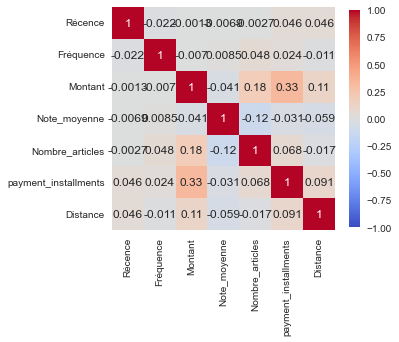

In [347]:
# Corrélation entre les variables

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data_3.corr(), annot=True, square=True, vmin=-1, vmax=+1,
            cmap=plt.colormaps.get_cmap('coolwarm'),
            cbar_kws={"shrink": 0.8})

In [348]:
# Suppression des valeurs manquantes
data_3.isnull().sum()

data_3 = data_3.dropna(subset='Distance')

## 4.1) Kmeans

In [349]:
# Standardisation des données
from sklearn.preprocessing import StandardScaler

col = data_3.columns.tolist()

scaler = StandardScaler()
data_3_scaled = pd.DataFrame(scaler.fit_transform(data_3[col]),
                             columns=col)

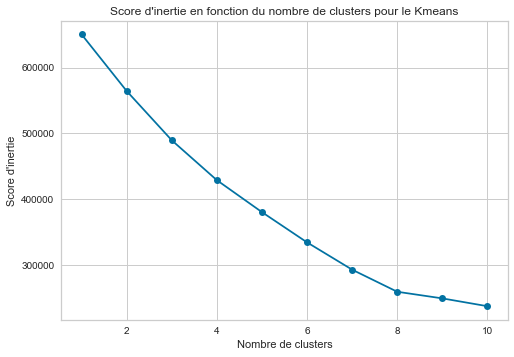

In [197]:
# On trace la courbe du score d'inertie à partir de notre fonction
score_inertie(data_3_scaled)

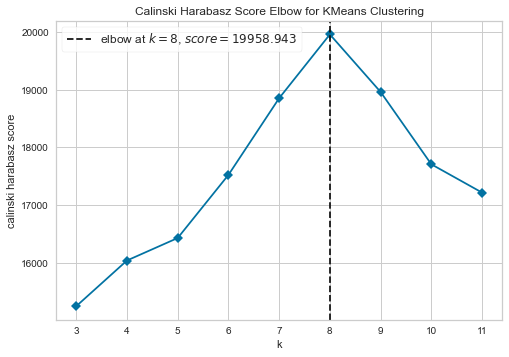

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

4:16: E231 missing whitespace after ','


In [198]:
# Calcul des scores de Calinski Harabasz en fonction du nombre de clusters
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(3,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(data_3_scaled)
visualizer.show()

D'après les résultats de la méthode du coude et du score Calinski Harabasz, le nombre optimal de clusters pour la Kmeans serait de **8**. 

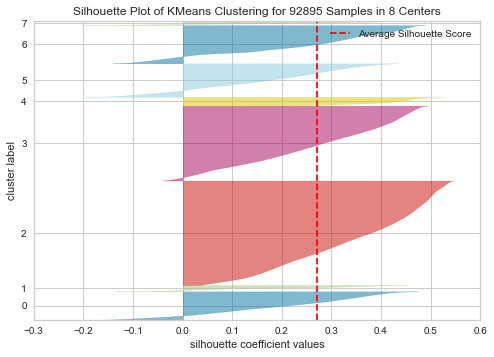

In [199]:
# Observons avec SilhouetteVisualizer la qualité de la clusterisation
from yellowbrick.cluster import SilhouetteVisualizer

K = [8]

# Initialisation de l'algorithme KMeans avec différents nombres de clusters
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(data_3_scaled)
    visualizer.show()

### Pour k = 8

In [350]:
np.random.seed(42)

# Interprétation des clusters obtenus
kmeans = KMeans(n_init=10, n_clusters=8)
kmeans.fit(data_3_scaled)
data_3['Clusters'] = (kmeans.labels_ + 1)

In [364]:
# On regroupe nos clusters en calculant leur moyenne pour chaque variable
group_mediane = data_3.groupby(['Clusters'])[col].mean()
group_mediane.style.bar(subset=group_mediane.columns.tolist())

,Récence,Fréquence,Montant,Note_moyenne,Nombre_articles,payment_installments,Distance
Clusters,,,,,,,
1,241.638433,1.000000,168.965860,4.163062,1.054014,2.975918,2020579.021265
2,234.865248,1.020263,334.270547,3.431524,3.853524,3.715964,558074.026100
3,122.847272,1.000000,112.553345,4.700148,1.057550,1.800388,386160.819871
4,398.093472,1.000000,112.581870,4.644914,1.062787,1.971807,443452.474298
5,220.718761,2.115847,143.611364,4.218248,1.225184,3.276821,556956.446376
6,248.431827,1.000000,250.430049,4.373558,1.109615,8.270288,531264.807450
7,231.613830,1.000000,132.930446,1.653963,1.146972,2.320405,501919.157776
8,236.565938,1.002261,1425.467031,4.055011,1.167295,6.662271,849840.894585


Interprétation des différents clusters : 
- **Cluster 4** : anciens clients ayant effectué un seul achat, à montants très faibles, très satisfaits. 
- **Cluster 7** : clients non satisfaits, dépenses faibles. 
- **Cluster 2** : clients assez satisfaits, avec de bonnes dépenses achetant en moyenne 3 articles par commande et effectuant plusieurs paiements. 
- **Cluster 3** : clients très satisfaits les plus récents, faibles dépenses. 
- **Cluster 8** : clients très satisfaits, les plus dépensiers, effectuant de nombreux virements. 
- **Cluster 5** : clients plutôt satisfaits, dépenses assez faibles, effectuant plusieurs commandes et quelques virements. 
- **Cluster 6** : clients très satisfaits, avec de bonnes dépenses, effectuant de nombreux virement. 
- **Cluster 1** : clients très satisfaits, effectuant quelques virements, distances entre le client et le vendeur très élevées. 

In [352]:
def func(row):
    if row['Clusters'] == 4:
        return 'Anciens clients très satisfaits, dépenses faibles'
    elif row['Clusters'] == 7:
        return 'Clients non satisfaits, dépenses faibles'
    elif row['Clusters'] == 2:
        return ('Clients assez satisfaits, bonnes dépenses, '
                'plusieurs articles par commande')
    elif row['Clusters'] == 3:
        return ('Clients les plus récents, très satisfaits, '
                'faibles dépenses, faibles distances des vendeurs')
    elif row['Clusters'] == 8:
        return 'Clients très satisfaits, très dépensiers, nombreux virements'
    elif row['Clusters'] == 5:
        return ('Clients assez satisfaits, '
                'dépenses faibles, plusieurs commandes effectuées')
    elif row['Clusters'] == 6:
        return 'Clients très satisfaits, nombreux virement'
    else:
        return 'Clients très satisfaits, à grandes distances des vendeurs'

In [353]:
data_3['Clients'] = data_3.apply(func, axis=1)

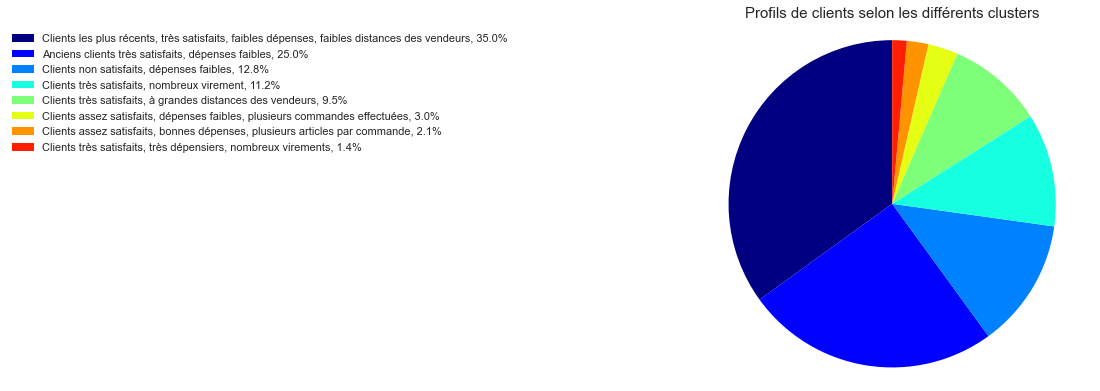

In [354]:
# On trace notre diagramme en camembert selon les différents clusters
pie(data_3, 'Clients', 'Profils de clients selon les différents clusters')

In [355]:
# Création d'une nouvelle fonction prenant en compte 5 variables

def trans_var_7(var1, var2, var3, var4, var5, var6,
                var7, df):
    # On sélectionne les variables à utiliser
    var = [var1, var2, var3, var4, var5, var6, var7]

    # On met à l'échelle de 0 à 100
    new_max = 100
    new_min = 0
    new_range = new_max - new_min

    # Transformation linéaire pour chaque variable
    for factor in var:
        max_val = group_mediane[factor].max()
        min_val = group_mediane[factor].min()
        val_range = max_val - min_val
        df[factor + '_Adj'] = df[factor].apply(
          lambda x: (((x - min_val) * new_range) / val_range) + new_min)
    return df

In [356]:
# Création d'une nouvelle fonction affichant la carte radar multiple

def radar_chart_7(new_var1, new_var2, new_var3, new_var4, new_var5,
                  new_var6, new_var_7, new_df):
    var = [new_var1, new_var2, new_var3, new_var4, new_var5, new_var6,
           new_var_7]

    fig = go.Figure()

    for i in range(1, new_df.shape[0] + 1):
        fig.add_trace(go.Scatterpolar(
          r=new_df.loc[i, var].tolist(),
          theta=var,
          fill='toself',
          name=i
        ))
    fig.show()

In [357]:
# Création de nos nouvelles variables mises à l'échelle
radar_8 = trans_var_7('Récence', 'Fréquence', 'Montant', 'Nombre_articles',
                      'Note_moyenne', 'payment_installments',
                      'Distance', group_mediane)

In [358]:
# On renomme nos nouvelles colonnes
radar_8 = radar_8.rename(columns={'Récence_Adj': 'Commandes_récentes',
                                  'Fréquence_Adj': 'Nombre_commandes',
                                  'Montant_Adj': 'Dépenses_commandes',
                                  'Nombre_articles_Adj': 'Nombre_articles',
                                  'Note_moyenne_Adj': 'Note_moyenne',
                                  'payment_installments_Adj':
                                  'Nombre_virements',
                                  'Distance_Adj': 'Distance'})
radar_8 = radar_8.iloc[:, 7:14]

In [359]:
# On affiche notre carte radar
radar_chart_7('Commandes_récentes', 'Nombre_commandes', 'Dépenses_commandes',
              'Nombre_articles', 'Note_moyenne', 'Nombre_virements',
              'Distance', radar_8)

### Calcul scores

In [210]:
import time

start_time = time.time()

# On applique le KMeans sur nos données standardisées
kmeans = KMeans(n_init=10, n_clusters=8)
kmeans.fit(data_3_scaled)

# On prédit les clusters pour chaque observation,
# puis on les stocke dans la variable "labels"
labels_kmeans = kmeans.predict(data_3_scaled)

In [211]:
# On calcule le score silhouette
silhouette_kmeans = silhouette_score(data_3_scaled, labels_kmeans)

In [212]:
# On calcule l'indice de Davies-Bouldin
db_kmeans = davies_bouldin_score(data_3_scaled, labels_kmeans)

In [213]:
# On calcule l'indice de Calinski-Harabasz
ch_kmeans = calinski_harabasz_score(data_3_scaled, labels_kmeans)

end_time = time.time()
kmeans_time = end_time - start_time

In [214]:
resultat_kmeans = pd.DataFrame(
    {'Silhouette_score': silhouette_kmeans,
     'Davies_bouldin_score': db_kmeans,
     'Calinski_harabasz_score': ch_kmeans,
     'Time': kmeans_time}, index=['Kmeans'])

resultat_kmeans

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.270539,1.045519,19959.000841,99.53103


## 4.2) DBSCAN

In [215]:
# On utilise une autre gamme de valeurs pour les paramètres
np.random.seed(123)
eps_values = np.arange(0.1, 1, 0.1)
min_samples = np.arange(2, 20, 2)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:13<00:00, 21.45s/it]


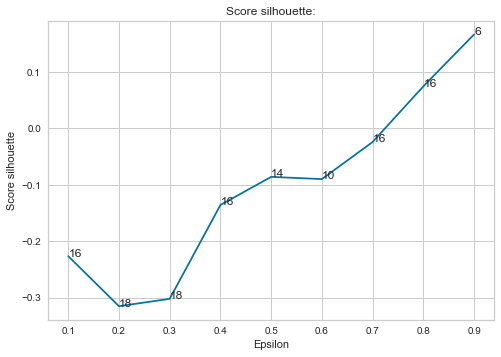

In [216]:
# On cherche les paramètres optimaux pour DBSCAN

np.random.seed(42)

sample = data_3_scaled.sample(n=10000, random_state=42)
eps_values, min_samples,
silhouette = dbscan_params(eps_values, min_samples, sample)

In [265]:
np.random.seed(42)

start_time = time.time()

# Paramètres de DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=6, metric='euclidean')

In [266]:
# Entraîner le modèle DBSCAN
model = dbscan.fit(data_3_scaled)
clusters = dbscan.fit_predict(data_3_scaled)


# Prédiction des labels des clusters
labels_dbscan = model.labels_

In [267]:
# On calcule le score silhouette pour DBSCAN
silhouette_dbscan = silhouette_score(data_3_scaled, labels_dbscan)

In [268]:
# On calcule l'indice de Calinski-Harabasz
ch_dbscan = calinski_harabasz_score(data_3_scaled, labels_dbscan)

end_time = time.time()
dbscan_time = end_time - start_time

In [269]:
resultat_dbscan = pd.DataFrame(
    {'Silhouette_score': silhouette_dbscan,
     'Davies_bouldin_score': db_dbscan,
     'Calinski_harabasz_score': ch_dbscan,
     'Time': dbscan_time}, index=['DBSCAN'])

resultat_dbscan

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
DBSCAN,0.161984,1.610259,1005.732687,316.654359


In [270]:
# Visualisation des clusters
data_dbscan = data_3[['Récence', 'Fréquence', 'Montant', 'Note_moyenne',
                      'Nombre_articles', 'payment_installments', 'Distance']]
data_dbscan.loc[:, 'Cluster'] = labels_dbscan
data_dbscan.groupby(
    ['Cluster']).median().style.bar(
    subset=['Récence', 'Fréquence', 'Montant', 'Note_moyenne',
            'Nombre_articles', 'payment_installments', 'Distance'])

,Récence,Fréquence,Montant,Note_moyenne,Nombre_articles,payment_installments,Distance
Cluster,,,,,,,
-1,254.000000,1.000000,518.035000,4.000000,2.000000,5.500000,777752.381216
0,219.000000,1.000000,98.430000,5.000000,1.000000,2.000000,434559.047576
1,219.000000,1.000000,150.780000,5.000000,2.000000,2.000000,412088.413002
2,175.000000,1.000000,201.580000,5.000000,4.000000,1.000000,328630.093180
3,197.000000,2.000000,100.030000,5.000000,1.000000,2.000000,399258.420183
4,206.000000,1.000000,191.140000,4.000000,3.000000,2.000000,393006.076088
5,203.000000,1.000000,212.310000,5.000000,6.000000,1.000000,144977.101579
6,164.500000,3.000000,84.035833,5.000000,1.000000,1.875000,344427.725683
7,208.500000,1.000000,214.040000,1.000000,4.000000,1.000000,359394.423401


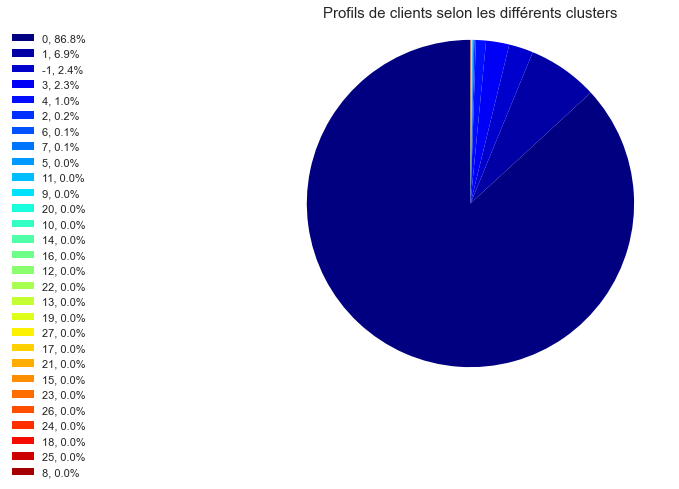

In [271]:
# On trace notre diagramme en camembert selon les différents clusters
pie(data_dbscan, 'Cluster', 'Profils de clients selon les différents clusters')

16 clusters sont identifiés dont un contenant du bruit (3.4% des données). Néanmoins, un cluster reste toujours majoritaire (87% des données) et le reste ne représente qu'une infime partie des données. Donc, clusters toujours **très hétérogènes**.

## 4.3) CAH

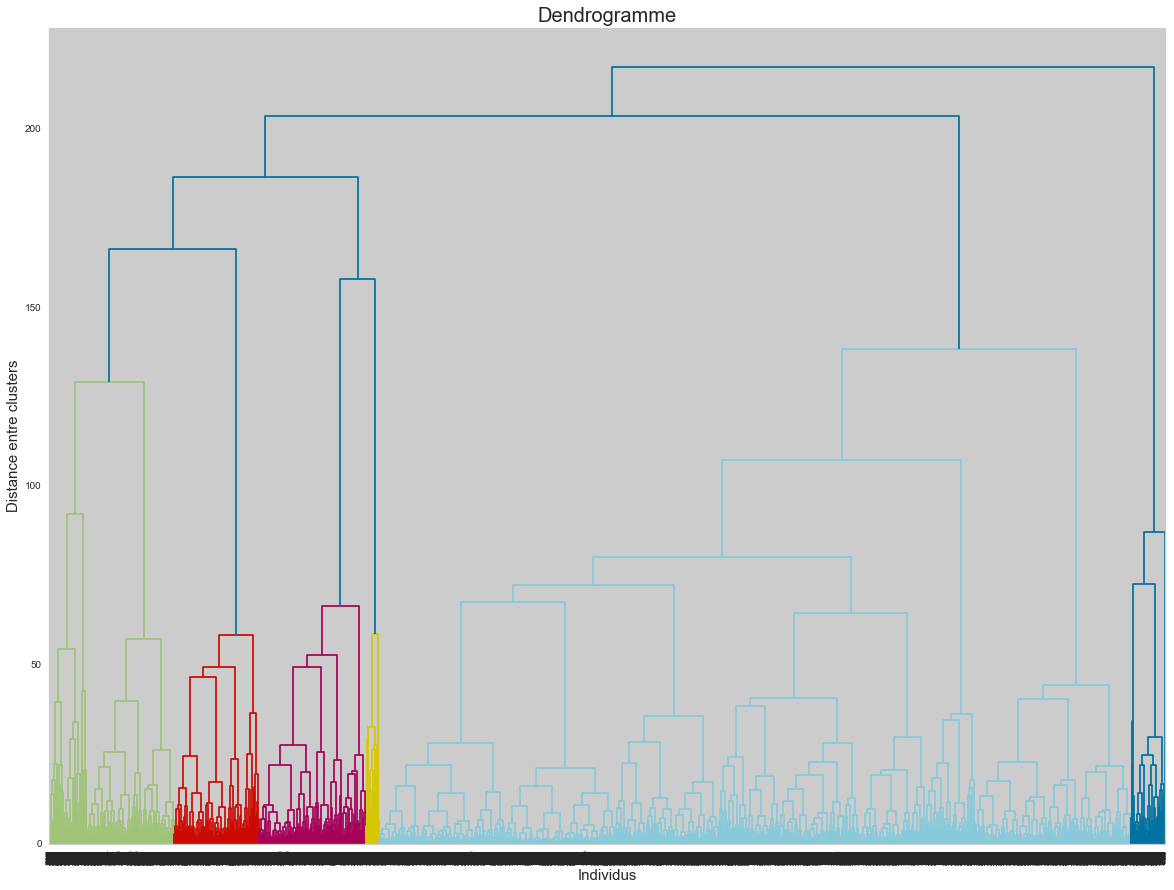

In [224]:
# Sélection d'un échantillon aléatoire
data_cah_3 = data_3_scaled.sample(frac=0.3, random_state=42)

# Calcul matrice de liaison
link = linkage(data_cah_3, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(20, 15))
dendrogram(link, orientation='top', distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme', size=20)
plt.xlabel("Individus", size=15)
plt.ylabel("Distance entre clusters", size=15)

plt.show()

In [272]:
from sklearn.cluster import AgglomerativeClustering

start_time = time.time()

# On calcule le score silhouette
clustering = AgglomerativeClustering(n_clusters=6).fit(data_cah_3)
silhouette_cah = silhouette_score(data_cah_3, clustering.labels_)

In [273]:
# On calcule le score Davies-Bouldin
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(data_cah_3)
cluster = model.fit_predict(data_cah_3)

davies_bouldin_CAH = davies_bouldin_score(data_cah_3, cluster)

In [274]:
# On calcule le score Calinski-Harabasz
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(data_cah_3)
cluster = model.fit_predict(data_cah_3)

CH_cah = calinski_harabasz_score(data_cah_3, cluster)

end_time = time.time()
CH_time = end_time - start_time

In [275]:
resultat_CAH = pd.DataFrame(
    {'Silhouette_score': silhouette_cah,
     'Davies_bouldin_score': davies_bouldin_CAH,
     'Calinski_harabasz_score': CH_cah,
     'Time': CH_time}, index=['CAH'])

resultat_CAH

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
CAH,0.316744,1.220026,4437.852706,270.200598


In [276]:
# On regroupe les résultats de scores pour
# nos différentes méthodes de clustering
pd.concat([resultat_kmeans, resultat_dbscan, resultat_CAH], axis=0)

,Silhouette_score,Davies_bouldin_score,Calinski_harabasz_score,Time
Kmeans,0.270539,1.045519,19959.000841,99.531030
DBSCAN,0.161984,1.610259,1005.732687,316.654359
CAH,0.316744,1.220026,4437.852706,270.200598


## Catégories produits par clusters

On va chercher à regarder, pour les clients, quelles sont les 5 catégories de produits principales pour chaque cluster de clients. 

In [360]:
data_3_copy = data_3.copy().reset_index()
data_merge = pd.merge(data_3_copy, df[['product_category_name_english',
                                       'categorie_commune',
                                       'customer_unique_id']],
                      on='customer_unique_id', how='left')

In [361]:
# Compter le nombre d'occurrences de chaque catégorie pour chaque cluster
count = data_merge.groupby(['Clusters',
                            'categorie_commune']).size().reset_index(
    name='count')

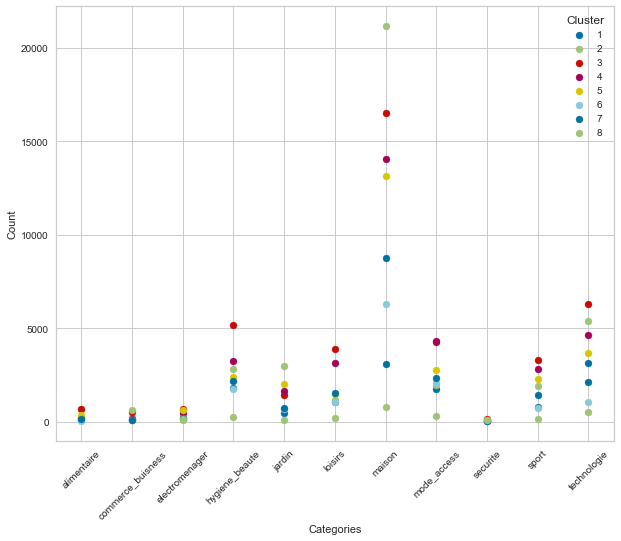

In [362]:
# Créer un nuage de points avec les 5 principales catégories par cluster
fig, ax = plt.subplots(figsize=(10, 8))

for cluster, group in count.groupby('Clusters'):
    ax.scatter(group['categorie_commune'], group['count'],
               label=cluster)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

Le nuage de points nous montre le nombre d'occurrence de chaque catégorie commune des produits pour chaque cluster correspondant. 

La catégorie maison est la plus représentative pour le cluster 3 (clients assez satisfaits, avec de bonnes dépenses achetant en moyenne 3 articles par commande et effectuant plusieurs paiements). 

On va plutôt regarder dans le détail les catégories principales pour chaque cluster:

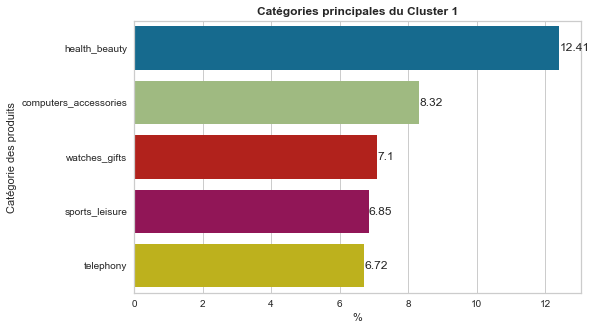

Ce cluster correspond aux ['Clients très satisfaits, à grandes distances des vendeurs'] .


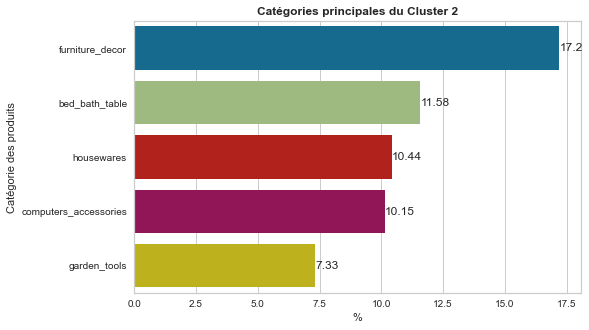

Ce cluster correspond aux ['Clients assez satisfaits, bonnes dépenses, plusieurs articles par commande'] .


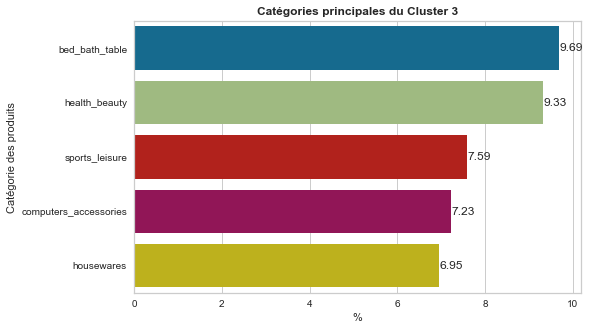

Ce cluster correspond aux ['Clients les plus récents, très satisfaits, faibles dépenses, faibles distances des vendeurs'] .


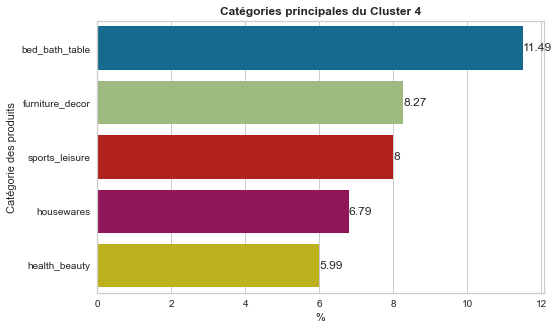

Ce cluster correspond aux ['Anciens clients très satisfaits, dépenses faibles'] .


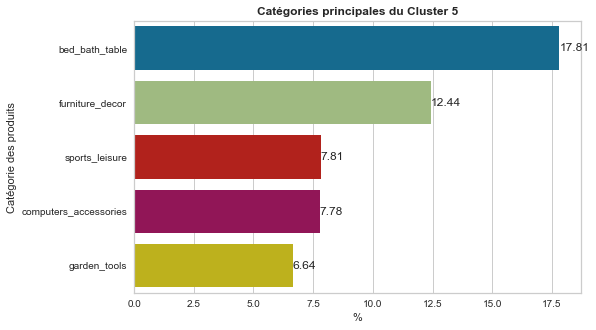

Ce cluster correspond aux ['Clients assez satisfaits, dépenses faibles, plusieurs commandes effectuées'] .


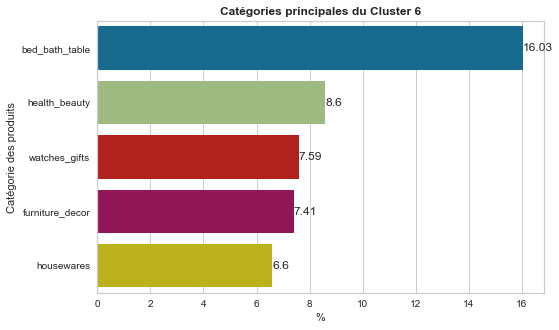

Ce cluster correspond aux ['Clients très satisfaits, nombreux virement'] .


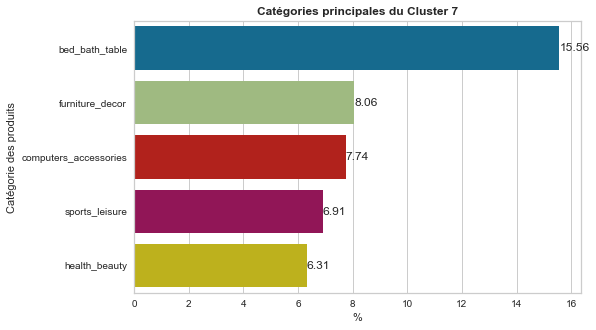

Ce cluster correspond aux ['Clients non satisfaits, dépenses faibles'] .


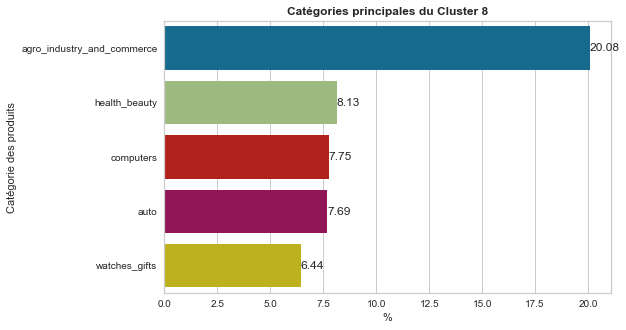

Ce cluster correspond aux ['Clients très satisfaits, très dépensiers, nombreux virements'] .


In [363]:
# On effectue un barplot pour chaque cluster

# On crée une liste des différents clusters
cluster = data_merge['Clusters'].sort_values().unique().tolist()

for c in cluster:
    cl = data_merge[data_merge['Clusters'] == c]
    cl_categ = pd.DataFrame(round(cl[
        'product_category_name_english'].value_counts()*100/cl.shape[
        0], 2)).head(5).reset_index()

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=cl_categ['product_category_name_english'],
                     y=cl_categ['index'])
    plt.title('Catégories principales du Cluster ' + str(c),
              fontweight='bold', size=12)
    plt.xlabel('%')
    plt.ylabel('Catégorie des produits')
    for i in ax.containers:
        ax.bar_label(i,)

    plt.show()
    print('Ce cluster correspond aux', cl['Clients'].unique(), '.')

In [234]:
# On enregistre notre dernier df
col = ['Récence', 'Fréquence', 'Montant', 'Note_moyenne',
       'Nombre_articles', 'payment_installments', 'Distance']

data_3 = data_3[col]
data_3.to_csv('maintenance.csv', sep=';')

Selon les clusters, on observe des différences dans les catégories de produits achetés en majorité. 

On observe dans un premier temps que les clusters 3, 4, 5, 6 et 7 ont acheté en majorité des produits de type "lit, bain, table". La caractéristique commune pour ces clients est que leurs dépenses restent assez basses. 

Le **cluster 1** est constitué de clients très satisfaits et situés à grande distance des vendeurs. Ces clients achètent essentiellements des produits de **"beauté et d'hygiène"**. Ces clients achètent également des produits technologiques comme les accessoires d'ordinateurs, les cadeaux/montres, téléphonie, ... Des produits difficilement trouvables localement.

Le **cluster 2** est constitué de clients achetant plusieurs articles par commande et avec de bonnes dépenses, achetant des produits de type **"meubles et décors"**, on peut supposer que ces achats puissent être effectués plusieurs fois. 

Le **cluster 8** est constitué de clients dépensant de grosses sommes et achetant principalement des produits de type **"agro industrie et commerce"**. On peut supposer que les clients effectuant des achats sont des professionnels dans l'industrie agroalimentaire et/ou des commerçants essentiellement. Ce sont des clients pouvant être amenés à acheter ultérieurement. 

Les clients anciens ont principalement achetés des produits de type "lit, bain, table", tout comme les clients les plus récents, et tout comme les clients ayant effectué plusieurs commandes. On peut supposer que ces clients puissent être amenés à commander à nouveau sur le site, étant donné leur niveau de satisfaction. 